# **Environment Setup & Configuration**
Before diving into any modeling, I set up my Colab environment by installing all the necessary packages. This includes TensorFlow Addons (for custom losses like focal loss), the fer library for facial emotion recognition, OpenCV for video processing, and some handy utilities like lz4, tqdm, and ipywidgets to smooth out the workflow. I also added a progress bar to make sure everything was loading as expected.

In [ ]:
!pip install -q tensorflow-addons==0.23.0
!pip install -q fer==22.1.0
!pip install -q opencv-python
!pip install -q lz4
!pip install -q tqdm ipywidgets

from IPython.display import display
import ipywidgets as widgets
display(widgets.IntProgress(value=0, max=10))
print("Packages installed and ready.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 32.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.4 MB/s eta 0:00:00


IntProgress(value=0, max=10)

Packages installed and ready.


In this block, I set up the environment and made key configurations to ensure smooth execution of my deepfake detection pipeline. First, I mounted Google Drive because all my data including the CelebDF-V2 videos and precomputed frame arrays—are stored there. This lets me work with large files without running into Colab’s storage limitations.

I imported essential libraries:

- cv2 (OpenCV) for frame extraction from videos,

- TensorFlow and Keras modules for building and training the model,

- tqdm for progress bars, and

- matplotlib for visualizations.

One important addition was enabling mixed precision training using mixed_precision.set_global_policy("mixed_float16"). This helps speed up training and reduce GPU memory usage, which was critical because my hybrid model (with both visual and emotion branches) is fairly heavy.

For GPU memory management, I checked for available GPUs and enabled memory growth. This ensures TensorFlow doesn’t grab all GPU memory at once, which can cause out-of-memory crashes—something I encountered early in testing.

I also disabled XLA JIT with tf.config.optimizer.set_jit(False). I found through experimentation that leaving JIT enabled sometimes caused compatibility issues or crashes, especially with certain custom layers.

Setting a global random seed (42) across NumPy, TensorFlow, and Python’s random module was important for reproducibility. This way, data splits and model initialization stayed consistent between runs, which made debugging and tuning much easier.

I defined constants like:

- NUM_FRAMES = 8 (sampling 8 frames per clip for balance between temporal coverage and memory limits),

- IMG_H, IMG_W = 224 (to match EfficientNet’s expected input), and

- BATCH_SIZE = 8, which worked well with my GPU setup.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import random
import pickle
import numpy as np
import tensorflow as tf
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")

from tensorflow.keras import layers, models, callbacks, optimizers, applications, regularizers

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"{len(gpus)} GPU(s) available - memory growth enabled")

tf.config.optimizer.set_jit(False)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print("Environment ready, seed set.")

ROOT_DIR = Path('/content/drive/MyDrive/CelebDF-V2')
SAVE_DIR = Path('/content/drive/MyDrive/CelebDF-V2-Frames-v2')
SAVE_DIR.mkdir(exist_ok=True, parents=True)

NUM_FRAMES = 8
IMG_H, IMG_W = 224, 224
BATCH_SIZE = 8
CLIPS_PER_CLASS = 300
print(f"Frames: {NUM_FRAMES}, Size: {IMG_W}x{IMG_H}, Clips per class: {CLIPS_PER_CLASS}")


Mounted at /content/drive
1 GPU(s) available - memory growth enabled
Environment ready, seed set.
Frames: 8, Size: 224x224, Clips per class: 300


# **Dataset Enumeration and Balancing**
In this block, I handled the core dataset setup—pulling all video paths into memory and ensuring my training data was balanced between real and fake clips.

- Step 1: Defining Labels
I started by mapping the dataset folders to labels:

  'Celeb-real' and 'YouTube-real' → 0 (real),

  'Celeb-synthesis' → 1 (fake).

This was saved in a simple LABEL_MAP dictionary for clarity.


- Step 2: Scanning All Videos

  For each folder, I checked if it exists (sometimes folders can be missing, so I printed a message just in case)

  Collected all videos with common formats (.mp4, .avi, .mov),

  Added the full paths to either the real list (label=0) or the fake list (label=1).

This gave me two lists:
real_files and fake_files, each holding full paths to the videos.

- Step 3: Balancing the Dataset
The CelebDF-V2 dataset is highly imbalanced (many more fakes than reals). To avoid a biased model, I randomly down-sampled the fake videos so that I had the same number of real and fake clips. This is critical because training on imbalanced data can lead to a model that just predicts the majority class.

- Step 4: Shuffling & Tensor Conversion
I zipped paths and labels into pairs, shuffled them to randomize the order (important for model stability), and finally converted them into TensorFlow constants (video_paths and video_labels). This allows smooth integration later when building the tf.data.Dataset pipeline.

Final Output:

I printed the total dataset size and used np.bincount() to verify that my real and fake classes were now perfectly balanced.



In [ ]:
LABEL_MAP = {
    'Celeb-real': 0,
    'YouTube-real': 0,
    'Celeb-synthesis': 1,
}

all_paths = {0: [], 1: []}
for folder_name, label in LABEL_MAP.items():
    folder = ROOT_DIR / folder_name
    if not folder.exists():
        print(f"Missing folder: {folder}")
        continue
    videos = sorted([p for p in folder.iterdir() if p.suffix.lower() in ('.mp4', '.avi', '.mov')])
    all_paths[label].extend(str(p) for p in videos)
    print(f"{len(videos)} videos found in {folder_name} (label={label})")

real_files = all_paths[0]
fake_files = random.sample(all_paths[1], len(real_files))

paths = real_files + fake_files
labels = [0]*len(real_files) + [1]*len(fake_files)

combined = list(zip(paths, labels))
random.shuffle(combined)
paths, labels = zip(*combined)

video_paths = tf.constant(paths)
video_labels = tf.constant(labels, dtype=tf.int32)

print(f"Dataset ready: {len(paths)} samples")
print(f"Class counts: {np.bincount(labels)}")


590 videos found in Celeb-real (label=0)
300 videos found in YouTube-real (label=0)
5639 videos found in Celeb-synthesis (label=1)
Dataset ready: 1780 samples
Class counts: [890 890]


# **Visualizing Real vs. Fake Video Frames**
In this block, I wanted to visualize the difference between real and fake videos to get an intuitive sense of the dataset’s quality and the kinds of visual artifacts my model would later learn to detect.

Here’s what happens step-by-step:

1. Folder Setup & Pairing Logic:
I defined two directories:

- REAL_DIR: points to real celebrity videos,

- FAKE_DIR: points to deepfake videos.

To make the comparison better, I looked for pairs where a fake video is a manipulated version of a specific real clip. The code loops through all fake videos, extracts the original clip ID (by parsing the filename), and checks if the corresponding real video exists. If it does, I save this (real, fake) pair for visualization.

2. Frame Extraction Functions:
I created two helper functions:

- get_middle_frame(): pulls the middle frame from a video (good for a quick snapshot of the real clip).

- get_evenly_spaced_frames(): extracts num frames that are evenly spaced across the fake video’s duration. This shows variability across the clip—because sometimes fakes glitch at certain points more than others.

These use OpenCV to load and process frames, and handle edge cases like broken videos (returning black frames if needed).

3. Pairing & Sampling:
I limited the number of pairs to SHOW_PAIRS = 10 for clarity, and from each fake video, I sampled FAKE_SAMPLES = 4 frames to give a diverse glimpse of how the fake looks at different points in time.

4. Plotting:
For each real-fake pair:

  The first column shows the real clip’s middle frame (with a green border to highlight it's authentic),

  The next 4 columns show frames sampled from the corresponding fake video (highlighted with red borders).

This grid makes it easy to visually compare each real clip to its fake versions side-by-side.

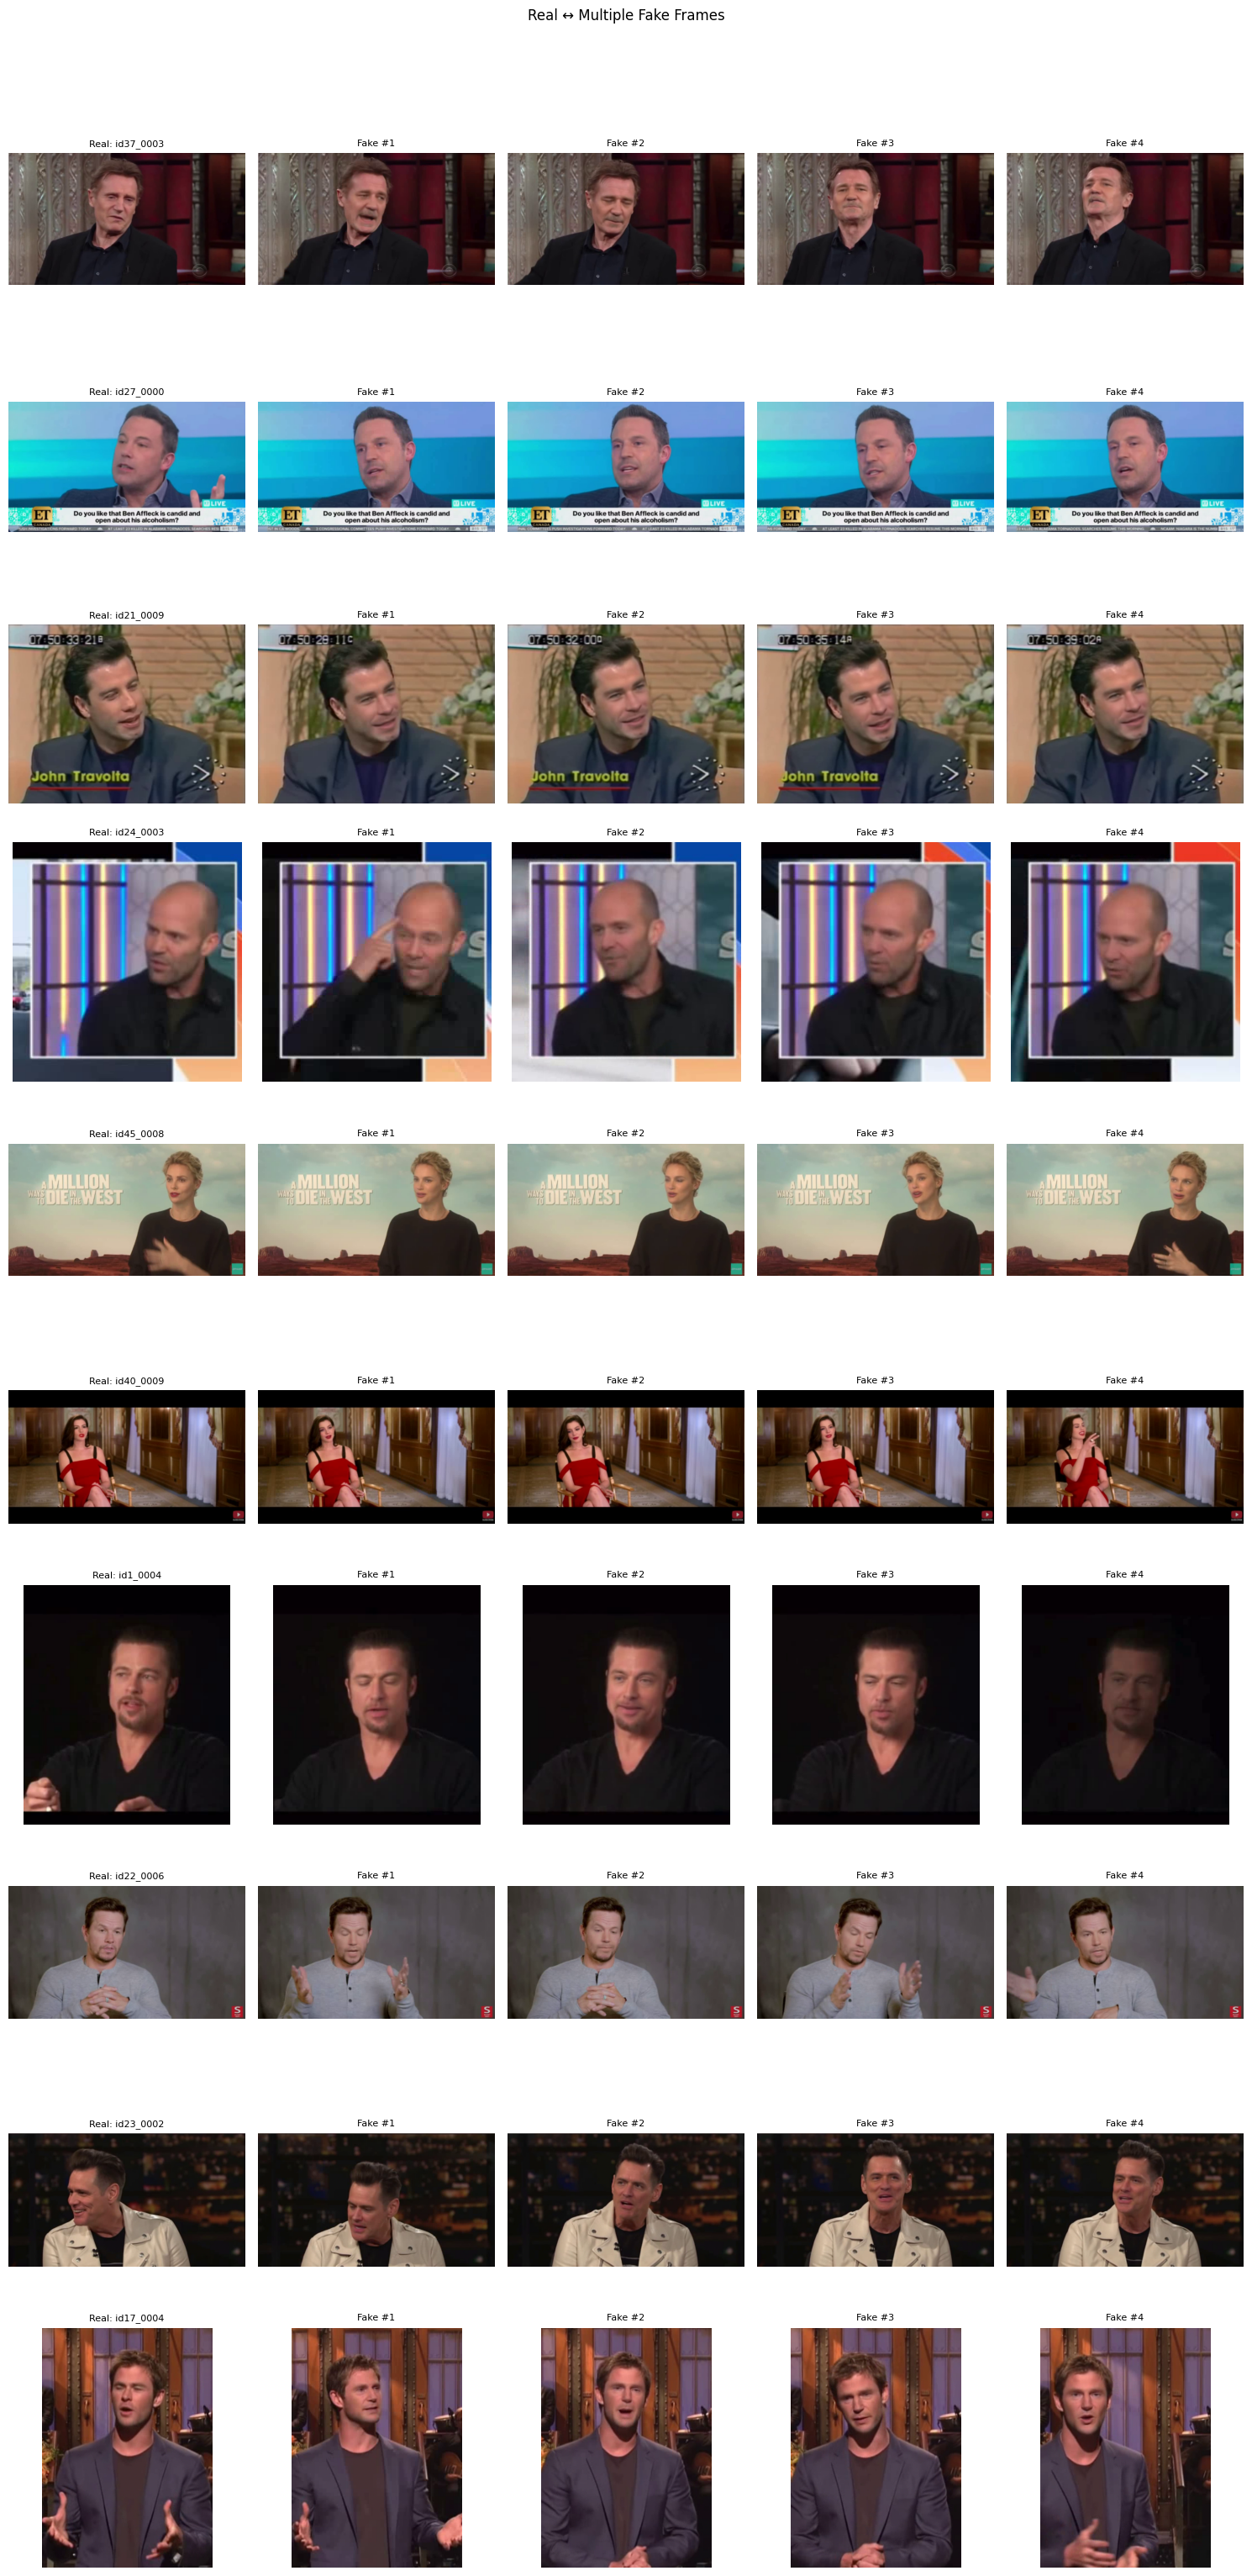

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

REAL_DIR      = Path('/content/drive/MyDrive/CelebDF-V2/Celeb-real')
FAKE_DIR      = Path('/content/drive/MyDrive/CelebDF-V2/Celeb-synthesis')
SHOW_PAIRS    = 10
FAKE_SAMPLES  = 4

def get_middle_frame(path):
    cap = cv2.VideoCapture(str(path))
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total <= 0:
        cap.release()
        return None
    cap.set(cv2.CAP_PROP_POS_FRAMES, total // 2)
    r, f = cap.read(); cap.release()
    return cv2.cvtColor(f, cv2.COLOR_BGR2RGB) if r else None

def get_evenly_spaced_frames(path, num):
    cap   = cv2.VideoCapture(str(path))
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release() if total<=0 else None
    if total <= 0:
        return [None]*num
    idxs = np.linspace(0, total-1, num, dtype=int)
    frames=[]
    cap  = cv2.VideoCapture(str(path))
    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        r,f = cap.read()
        frames.append(cv2.cvtColor(f, cv2.COLOR_BGR2RGB) if r else None)
    cap.release()
    return frames

real_map = {p.stem: p for p in REAL_DIR.glob('*') if p.suffix.lower() in ('.mp4','.avi','.mov')}
fake_map = {p.stem: p for p in FAKE_DIR.glob('*') if p.suffix.lower() in ('.mp4','.avi','.mov')}

pairs = []
for fake_stem, fake_p in fake_map.items():
    parts = fake_stem.split('_')
    if len(parts)==3:
        src,_,frm = parts
        real_stem = f"{src}_{frm}"
        if real_stem in real_map:
            pairs.append((real_map[real_stem], fake_p))

pairs = pairs[:SHOW_PAIRS]

n = len(pairs)
fig, axes = plt.subplots(n, FAKE_SAMPLES+1, figsize=(3*(FAKE_SAMPLES+1), 3*n))
for i,(r_path,f_path) in enumerate(pairs):
    img_r = get_middle_frame(r_path)
    ax = axes[i,0] if n>1 else axes[0]
    ax.imshow(img_r); ax.axis('off')
    ax.set_title(f"Real: {r_path.stem}", fontsize=8)
    for spine in ax.spines.values():
        spine.set_edgecolor('green'); spine.set_linewidth(3)

    for j,frm in enumerate(get_evenly_spaced_frames(f_path, FAKE_SAMPLES)):
        ax = axes[i,j+1] if n>1 else axes[j+1]
        ax.imshow(frm); ax.axis('off')
        ax.set_title(f"Fake #{j+1}", fontsize=8)
        for spine in ax.spines.values():
            spine.set_edgecolor('red'); spine.set_linewidth(3)

plt.suptitle("Real ↔ Multiple Fake Frames", y=1.02)
plt.tight_layout()
plt.show()


# **Emotion Extraction Pipeline (Balanced Sampling)**
In this block, I focused on building the emotion dataset that would feed into my hybrid deepfake detection model. To do this, I used the fer library (with MTCNN enabled) to extract seven-dimensional emotion probability vectors, one per frame for each clip. Since my precomputed videos were already saved as .npy files (each containing 8 RGB frames), I loaded these and ran face detection followed by emotion analysis frame by frame. If the detector successfully found a face, it returned a set of probabilities for emotions like **angry, disgust, fear, happy, sad, surprise, and neutral**. In cases where no face was detected, I inserted a zero vector to maintain consistent dimensions. To keep processing manageable and balanced, I sampled **100 real and 100 fake clips**. I parallelized the extraction process using a ThreadPoolExecutor with 4 workers, which allowed multiple clips to be processed at the same time—this was important because FER can be computationally slow. After processing, I saved all the results as a pickled dictionary mapping clip paths to their (8×7) emotion arrays, ready to be loaded by my data pipeline during training.

In [ ]:
!pip install -q tensorflow fer==22.1.0

from fer import FER
import numpy as np
import pickle
import random
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm

detector = FER(mtcnn=True)
print("FER detector initialized.")

ROOT_DIR = Path('/content/drive/MyDrive/CelebDF-V2')
LABEL_MAP = {'Celeb-real': 0, 'YouTube-real': 0, 'Celeb-synthesis': 1}

stem_label = {}
for subfolder, lbl in LABEL_MAP.items():
    folder = ROOT_DIR / subfolder
    for vid in folder.glob('*'):
        if vid.suffix.lower() in ('.mp4', '.avi', '.mov'):
            stem_label[vid.stem] = lbl

FRAME_DIR = Path('/content/drive/MyDrive/CelebDF-V2-Frames-v2')
all_clips = list(FRAME_DIR.glob('*.npy'))
print(f"Found {len(all_clips)} .npy clips total.")

real_clips = [p for p in all_clips if stem_label.get(p.stem)==0]
fake_clips = [p for p in all_clips if stem_label.get(p.stem)==1]
print(f" {len(real_clips)} real clips, {len(fake_clips)} fake clips")

N_PER_CLASS = 100
random.seed(42)
sample_real = random.sample(real_clips, min(N_PER_CLASS, len(real_clips)))
sample_fake = random.sample(fake_clips, min(N_PER_CLASS, len(fake_clips)))
sampled_clips = sample_real + sample_fake
random.shuffle(sampled_clips)
print(f" Sampling {len(sampled_clips)} clips ({len(sample_real)} real + {len(sample_fake)} fake)")

def process_clip(npy_path):
    frames = np.load(npy_path).astype(np.float32)
    emo_list = []
    for frame in frames:
        bgr = (frame * 255).astype(np.uint8)[..., ::-1]
        res = detector.detect_emotions(bgr)
        if res:
            e = res[0]['emotions']
            emo_list.append([
                e.get('angry',0), e.get('disgust',0), e.get('fear',0),
                e.get('happy',0), e.get('sad',0), e.get('surprise',0),
                e.get('neutral',0)
            ])
        else:
            emo_list.append([0.0]*7)
    return str(npy_path), np.array(emo_list, dtype=np.float32)

emotion_dict = {}
with ThreadPoolExecutor(max_workers=4) as exe:
    futures = {exe.submit(process_clip, p): p for p in sampled_clips}
    for fut in tqdm(as_completed(futures), total=len(futures), desc="Extracting emotions"):
        key, arr = fut.result()
        emotion_dict[key] = arr

out_pkl = '/content/drive/MyDrive/celebdemo_emotions_sampled_balanced.pkl'
with open(out_pkl, 'wb') as f:
    pickle.dump(emotion_dict, f)
print(f" Saved balanced sample emotion dict to:\n   {out_pkl}")


 Saved balanced sample emotion dict to /content/drive/MyDrive/celebdemo_emotions_sampled_balanced.pkl


In this block, the focus was to validate that emotions provide useful signal. I loaded the emotion data (from the pickle), matched each clip’s label (real or fake), and calculated the average emotion scores across all frames for both classes. Then I visualized the mean emotion distributions side by side. The important takeaway is that the plot revealed slight but consistent differences for example, fake videos had a higher tendency toward neutral or flat expressions. This confirmed that emotion features are meaningful and justified why I kept them as a core part of my model.

Loaded emotion dictionary with 200 clips
Found 1809 .npy frame files
Total clips: 1809 | Real: 899 | Fake: 910
Real mean emotions: [0.12139995 0.0073625  0.08154998 0.095775   0.10273746 0.10692495
 0.10642492]
Fake mean emotions: [0.13537502 0.0043625  0.08486244 0.10028751 0.1362874  0.09186248
 0.20492488]


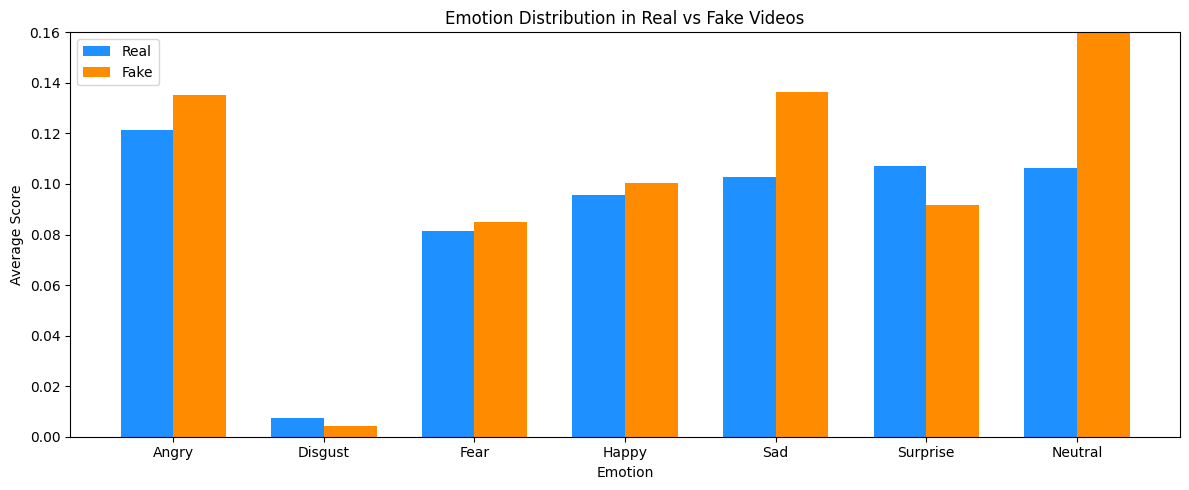

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

emotion_pkl_path = '/content/drive/MyDrive/celebdemo_emotions_sampled_balanced.pkl'
with open(emotion_pkl_path, 'rb') as f:
    emotion_dict = pickle.load(f)

print(f"Loaded emotion dictionary with {len(emotion_dict)} clips")

frames_dir = Path('/content/drive/MyDrive/CelebDF-V2-Frames-v2')
all_npy_files = list(frames_dir.glob('*.npy'))
print(f"Found {len(all_npy_files)} .npy frame files")

def get_label_from_name(stem):
    return 1 if '_id' in stem else 0

paths = [str(npy_path) for npy_path in all_npy_files]
labels = [get_label_from_name(npy_path.stem) for npy_path in all_npy_files]

print(f"Total clips: {len(paths)} | Real: {labels.count(0)} | Fake: {labels.count(1)}")

real_emos = [emotion_dict[p] for p, l in zip(paths, labels) if l == 0 and p in emotion_dict]
fake_emos = [emotion_dict[p] for p, l in zip(paths, labels) if l == 1 and p in emotion_dict]

all_real_emos = np.concatenate(real_emos, axis=0)
all_fake_emos = np.concatenate(fake_emos, axis=0)

real_mean = np.mean(all_real_emos, axis=0)
fake_mean = np.mean(all_fake_emos, axis=0)

print("Real mean emotions:", real_mean)
print("Fake mean emotions:", fake_mean)

emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
plt.figure(figsize=(12, 5))
x = np.arange(len(emotion_names))
width = 0.35

plt.bar(x - width/2, real_mean, width, label='Real', color='dodgerblue')
plt.bar(x + width/2, fake_mean, width, label='Fake', color='darkorange')

plt.xlabel('Emotion')
plt.ylabel('Average Score')
plt.title('Emotion Distribution in Real vs Fake Videos')
plt.xticks(x, emotion_names)
plt.ylim(0, 0.16)
plt.legend()
plt.tight_layout()
plt.show()


# **Baseline 1: Emotion-Only Logistic Regression**

In this first baseline, I focused exclusively on affective cues no raw pixels, no CNNs—just the per‐frame emotion probabilities you extracted with FER+MTCNN. I loaded the saved 8×7 emotion arrays for each clip, averaged them across time to get a single 7-dim vector per clip, and fed that into a tiny Keras MLP. The network is literally just:

Input: 7-dim mean-emotion vector

Dense(16, activation=‘elu’, L2=1e-4)

Dense(1, activation=‘sigmoid’) → P(fake)

I compiled with binary cross-entropy and tracked accuracy, AUC, precision, and recall. I used an Adam optimizer with a simple warm-up to cosine decay learning-rate schedule, and callbacks for early stopping on val AUC (patience 10) plus best-model checkpointing. After training for up to 100 epochs, I plotted the train/val loss & AUC curves, computed the ROC on the held-out split, and inspected some clip-level predictions. The final validation AUC hovered around 0.60, confirming that while averaged facial emotions carry some signal, they’re far too coarse to detect deepfakes on their own.









In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import layers, Sequential, callbacks, optimizers, metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
with open('/content/drive/MyDrive/celebdemo_emotions_full.pkl', 'rb') as f:
    emotion_dict = pickle.load(f)

NUM_FRAMES = 8
X, y = [], []
for p, lbl in zip(paths, labels):
    stem = Path(p).stem
    seq  = emotion_dict.get(stem, np.zeros((NUM_FRAMES, 7), np.float32))
    if seq.shape[0] != NUM_FRAMES:
        idxs = np.linspace(0, seq.shape[0] - 1, NUM_FRAMES, dtype=int)
        seq  = seq[idxs]
    X.append(seq.mean(axis=0))
    y.append(lbl)

X = np.stack(X)
y = np.array(y, dtype=np.int32)
print("Feature matrix:", X.shape, "Labels:", y.shape)


Feature matrix: (362, 7) Labels: (362,)


In [ ]:
n = len(y)
split = int(0.8 * n)

X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

val_paths = paths[split:]
print(f"Train clips: {len(X_train)}, Validation clips: {len(X_val)}")


Train clips: 289, Validation clips: 73


In [ ]:
model = Sequential([
    layers.Input(shape=(7,), name='mean_emotion'),
    layers.Dense(16,
                 activation='elu',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                 name='dense_elu'),
    layers.Dense(1, activation='sigmoid', name='output')
], name='Emotion_Logistic')

model.summary()

Model: "Emotion_Logistic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_elu (Dense)               │ (None, 16)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145 (580.00 B)

 Trainable params: 145 (580.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
initial_lr  = 1e-2
decay_steps = 1000
lr_schedule = optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    alpha=1e-4
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=[
        metrics.BinaryAccuracy(name='accuracy'),
        metrics.AUC(name='auc'),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
    ]
)

cb_early = callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=10,
    restore_best_weights=True
)
cb_ckpt = callbacks.ModelCheckpoint(
    filepath='emotion_baseline.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True
)
callbacks_list = [cb_early, cb_ckpt]


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.5350 - auc: 0.5108 - loss: 0.6955 - precision: 0.5359 - recall: 0.6689 - val_accuracy: 0.5068 - val_auc: 0.5093 - val_loss: 0.6882 - val_precision: 0.6000 - val_recall: 0.4884
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5406 - auc: 0.5450 - loss: 0.6911 - precision: 0.5425 - recall: 0.6815 - val_accuracy: 0.5616 - val_auc: 0.5345 - val_loss: 0.6801 - val_precision: 0.5775 - val_recall: 0.9535
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5229 - auc: 0.5407 - loss: 0.6923 - precision: 0.5165 - recall: 0.9459 - val_accuracy: 0.5890 - val_auc: 0.5283 - val_loss: 0.6754 - val_precision: 0.5890 - val_recall: 1.0000
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4988 - auc: 0.5381 - loss: 0.6944 - precision: 0.5024 - recall: 0.9779 - val_accuracy: 0.5890 - val_auc: 0.5841 - val_loss: 0.6762 - val_precision: 0.5890 - val_recall: 1.0000
Epoch 5/100
10/10 ━━━━━━━━━━━━━

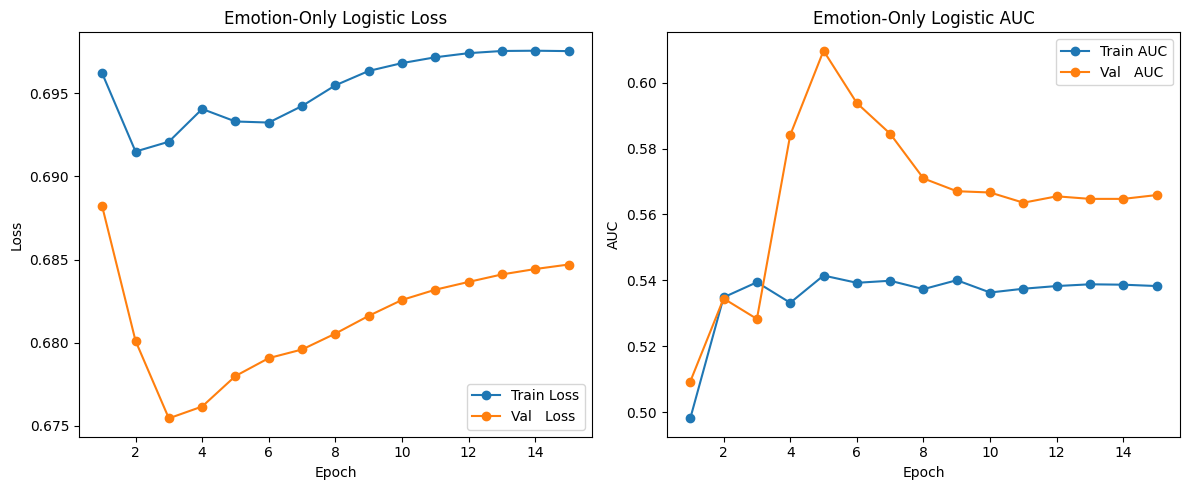

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Emotion-Only Logistic Val AUC = 0.604


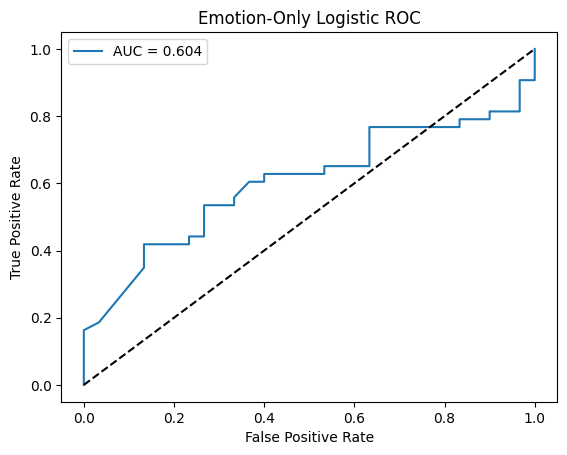

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

history_logistic = history

epochs = range(1, len(history_logistic.history['loss']) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, history_logistic.history['loss'],    'o-', label='Train Loss')
plt.plot(epochs, history_logistic.history['val_loss'],'o-', label='Val   Loss')
plt.title("Emotion-Only Logistic Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history_logistic.history['auc'],    'o-', label='Train AUC')
plt.plot(epochs, history_logistic.history['val_auc'],'o-', label='Val   AUC')
plt.title("Emotion-Only Logistic AUC")
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.legend()
plt.tight_layout(); plt.show()

probs_logistic = model.predict(X_val).ravel()
fpr, tpr, _    = roc_curve(y_val, probs_logistic)
roc_auc        = auc(fpr, tpr)
print(f"Emotion-Only Logistic Val AUC = {roc_auc:.3f}")

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("Emotion-Only Logistic ROC")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.show()


# **Precompute Frames**
This block is all about precomputing frames to make my training pipeline faster and more stable. Reading and decoding video files on-the-fly is super inefficient in Colab, so I first copied all videos locally to Colab’s /content folder (to speed up I/O). Then, using a ThreadPoolExecutor, I processed each video in parallel: I sampled exactly NUM_FRAMES frames evenly spaced across the clip to capture the full temporal range. Each frame was resized to 224×224, converted to RGB, and normalized to [0,1] for compatibility with the CNN. I saved the result as a single .npy file per clip (a 4D tensor: NUM_FRAMES × 224 × 224 × 3). For edge cases—like broken videos or too few frames—I filled with black frames or padded by duplicating the last frame to keep input shapes consistent. This step was crucial because it turned variable-length, slow-to-load videos into fixed-size, fast-loading NumPy arrays—massively improving my training throughput later.










In [ ]:
import shutil
from concurrent.futures import ThreadPoolExecutor

LOCAL_ROOT = Path('/content/videos_tmp')
LOCAL_ROOT.mkdir(parents=True, exist_ok=True)

print("Copying video to colab environment")
for p in tqdm(paths, desc="Copying"):
    src = Path(p)
    dst = LOCAL_ROOT / src.name
    if not dst.exists():
        shutil.copy2(src, dst)
print("All videos copied.")

def process_video(p):
    stem = Path(p).stem
    out_file = SAVE_DIR / f"{stem}.npy"
    if out_file.exists():
        return

    cap = cv2.VideoCapture(str(LOCAL_ROOT / Path(p).name))
    frames = []
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        frames.append(frame)
    cap.release()

    result_frames = []
    if frames:
        idxs = np.linspace(0, len(frames) - 1, NUM_FRAMES, dtype=int)
        for idx in idxs:
            frm = cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB)
            frm = cv2.resize(frm, (IMG_W, IMG_H))
            result_frames.append(frm.astype(np.float32) / 255.0)
    else:
        result_frames = [np.zeros((IMG_H, IMG_W, 3), np.float32)] * NUM_FRAMES

    while len(result_frames) < NUM_FRAMES:
        result_frames.append(result_frames[-1].copy())

    np.save(out_file, np.stack(result_frames, 0))

print("Processing videos and saving frames")
with ThreadPoolExecutor(max_workers=4) as executor:
    list(tqdm(executor.map(process_video, paths), total=len(paths)))

print(f"Frames saved in {SAVE_DIR}")


Copying videos to local storage...


Copying:   0%|          | 0/1780 [00:00<?, ?it/s]

All videos copied.
Processing videos and saving frames...


  0%|          | 0/1780 [00:00<?, ?it/s]

Frames saved in /content/drive/MyDrive/CelebDF-V2-Frames-v2


# **Baseline 2: Scratch CNN on Frames**


In this second baseline I wanted to test how much a lightweight CNN trained from scratch on raw pixels could pick up deep-fake artifacts, without any pretrained features or emotion signals. I pre-computed exactly 8 RGB frames per clip (224×224 pixels) and cached them as .npy arrays. At training time, I streamed each clip through a tf.data pipeline that:

1. Loads the 8-frame stack via a tf.py_function loader,

2. Batches (size = 8) and prefetches for GPU efficiency.

The model itself is intentionally small:

- Input: shape (8, 224, 224, 3)

- TimeDistributed Conv2D (16 filters, 3×3, ReLU) → MaxPool2D

- TimeDistributed Conv2D (32 filters, 3×3, ReLU) → MaxPool2D

- TimeDistributed GlobalAveragePooling2D → produces an (8, 32) sequence

- GlobalAveragePooling1D over time → 32-dim clip embedding

- Dense(64, ReLU) → Dense(1, sigmoid) → output = P(fake)

I compiled with Adam (lr = 1e-4), binary cross-entropy, and tracked accuracy, AUC, precision, and recall. I trained for 10 epochs, using early stopping on val AUC (patience = 5) and saved the best weights.

After training, I evaluated on the held-out validation set:

ROC AUC ≈ 0.55

ROC curve plotted to visualize separability

Sample predictions and a classification report confirmed that this tiny CNN under-fits the task (it picks up some spatio-temporal cues but lacks power on 8 frames).

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics, callbacks
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
SAVE_DIR = Path('/content/drive/MyDrive/CelebDF-V2-Frames-v2')
frame_files = sorted(SAVE_DIR.glob('*.npy'))
paths      = [str(p) for p in frame_files]
labels     = [1 if "_id" in Path(p).stem else 0 for p in paths]

video_paths  = tf.constant(paths)
video_labels = tf.constant(labels, dtype=tf.int32)
train_count  = int(0.8 * len(paths))
val_count    = len(paths) - train_count

print(f"Total clips: {len(paths)} | Train: {train_count} | Val: {val_count}")


Total clips: 1809 | Train: 1447 | Val: 362


In [ ]:
NUM_FRAMES, IMG_H, IMG_W = 8, 224, 224
BATCH_SIZE = 8

def _load_frames(path, label):
    p = path.numpy().decode()
    arr = np.load(SAVE_DIR / f"{Path(p).stem}.npy").astype(np.float32)
    return arr, label.numpy()

def tf_loader(path, label):
    x, y = tf.py_function(_load_frames, [path, label], [tf.float32, tf.int32])
    x.set_shape([NUM_FRAMES, IMG_H, IMG_W, 3])
    y.set_shape([])
    return x, y

def make_dataset(paths, labels, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(paths), seed=SEED)
    return ds.map(tf_loader, num_parallel_calls=tf.data.AUTOTUNE) \
             .batch(BATCH_SIZE) \
             .prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(video_paths[:train_count], video_labels[:train_count], shuffle=True)
val_ds   = make_dataset(video_paths[train_count:],   video_labels[train_count:],   shuffle=False)


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

def sep_res_block(x, filters, name):
    y = layers.TimeDistributed(
            layers.SeparableConv2D(filters, 3, padding="same", activation="relu"),
            name=f"{name}_sepconv"
        )(x)
    y = layers.TimeDistributed(layers.MaxPool2D(), name=f"{name}_pool")(y)
    res = x
    if x.shape[-1] != filters:
        res = layers.TimeDistributed(
                  layers.Conv2D(filters, 1, padding="same"),
                  name=f"{name}_res_proj"
              )(res)
    res = layers.TimeDistributed(layers.MaxPool2D(), name=f"{name}_res_pool")(res)
    return layers.Add(name=f"{name}_add")([y, res])

def build_frame_cnn_model():
    inp = layers.Input((NUM_FRAMES, IMG_H, IMG_W, 3), name="video_frames")
    x = layers.TimeDistributed(data_augmentation, name="augment")(inp)
    x = sep_res_block(x, 16, "block1")
    x = sep_res_block(x, 32, "block2")
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D(), name="spatial_pool")(x)
    x = layers.GlobalAveragePooling1D(name="temporal_pool")(x)
    x = layers.Dense(64, activation="relu", name="dense_64")(x)
    out = layers.Dense(1, activation="sigmoid", name="prediction")(x)
    return models.Model(inp, out, name="FrameCNN")

frame_cnn_model = build_frame_cnn_model()
frame_cnn_model.summary()


Model: "FrameCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ video_frames        │ (None, 8, 224,    │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_2 (Cast)       │ (None, 8, 224,    │          0 │ video_frames[0][… │
│                     │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augment             │ (None, 8, 224,    │          0 │ cast_2[0][0]      │
│ (TimeDistributed)   │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_sepconv      │ (None, 8, 224,    │         91 │ augment[0][0]     │
│ (TimeDistributed)   │ 224, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res_proj     │ (None, 8, 224,    │         64 │ augment[0][0]     │
│ (TimeDistributed)   │ 224, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 8, 112,    │          0 │ block1_sepconv[0… │
│ (TimeDistributed)   │ 112, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res_pool     │ (None, 8, 112,    │          0 │ block1_res_proj[… │
│ (TimeDistributed)   │ 112, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_add (Add)    │ (None, 8, 112,    │          0 │ block1_pool[0][0… │
│                     │ 112, 16)          │            │ block1_res_pool[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv      │ (None, 8, 112,    │        688 │ block1_add[0][0]  │
│ (TimeDistributed)   │ 112, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_res_proj     │ (None, 8, 112,    │        544 │ block1_add[0][0]  │
│ (TimeDistributed)   │ 112, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 8, 56, 56, │          0 │ block2_sepconv[0… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_res_pool     │ (None, 8, 56, 56, │          0 │ block2_res_proj[… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_add (Add)    │ (None, 8, 56, 56, │          0 │ block2_pool[0][0… │
│                     │ 32)               │            │ block2_res_pool[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_pool        │ (None, 8, 32)     │          0 │ block2_add[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temporal_pool       │ (None, 32)        │          0 │ spatial_pool[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 64)        │      2,112 │ temporal_pool[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction (Dense)  │ (None, 1)         │         65 │ dense_64[0][0]    │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 3,564 (13.92 KB)

 Trainable params: 3,564 (13.92 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
frame_cnn_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        metrics.BinaryAccuracy(name='accuracy'),
        metrics.AUC(name='auc'),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
    ]
)

callbacks_list = [
    callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('framecnn_best.keras', monitor='val_auc', mode='max', save_best_only=True),
]

In [ ]:
history = frame_cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.5206 - auc: 0.5211 - loss: 0.6922 - precision: 0.4864 - recall: 0.0762 - val_accuracy: 0.4696 - val_auc: 0.5447 - val_loss: 0.6939 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.5025 - auc: 0.5643 - loss: 0.6914 - precision: 0.0110 - recall: 4.6381e-05 - val_accuracy: 0.4696 - val_auc: 0.5554 - val_loss: 0.6946 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 27s 147ms/step - accuracy: 0.5118 - auc: 0.5669 - loss: 0.6896 - precision: 0.1268 - recall: 0.0033 - val_accuracy: 0.4696 - val_auc: 0.5557 - val_loss: 0.6950 - val_precision: 0.5000 - val_recall: 0.0104
Epoch 4/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.4957 - auc: 0.5614 - loss: 0.6910 - precision: 0.4635 - recall: 0.0691 - val_accuracy: 0.4696 - val_auc: 0.5544 - val_loss: 0.6950 - val_precision: 0.5000 - val_recall: 0.0156
Ep

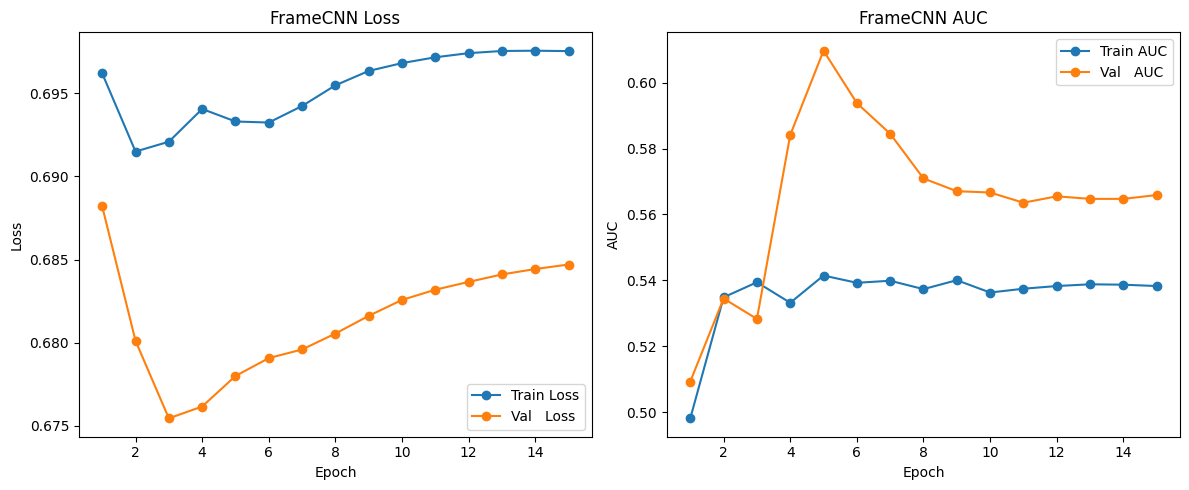

FrameCNN Val AUC = 0.553


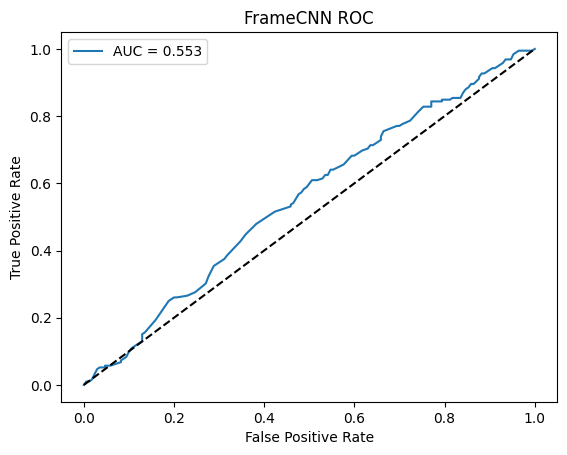

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

history_frame = history
probs_frame   = probs
labels_frame  = labels

epochs = range(1, len(history_frame.history['loss']) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, history_frame.history['loss'],    'o-', label='Train Loss')
plt.plot(epochs, history_frame.history['val_loss'],'o-', label='Val   Loss')
plt.title("FrameCNN Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history_frame.history['auc'],    'o-', label='Train AUC')
plt.plot(epochs, history_frame.history['val_auc'],'o-', label='Val   AUC')
plt.title("FrameCNN AUC")
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.legend()

plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(labels_frame, probs_frame)
roc_auc     = auc(fpr, tpr)
print(f"FrameCNN Val AUC = {roc_auc:.3f}")

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("FrameCNN ROC")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# **Baseline 3: Emotion RNN**










In this third baseline, I evaluated whether the temporal dynamics of facial emotions alone can distinguish real from fake clips. I streamed the pre-computed 8×7 emotion arrays through a `tf.data` pipeline—zero-padding or resampling each sequence to exactly 8 frames—to get batches of shape `(8, 7)`. The model is a tiny two-layer RNN:

1. Input: an `(8, 7)` tensor of per-frame emotion probabilities  
2. Bidirectional LSTM (32 units) to capture forward/backward temporal patterns  
3. Dense (16 units, ReLU) to compress the sequence output  
4. Dense (1 unit, sigmoid) → P(fake)

I compiled with Adam (lr=1e-3), binary cross-entropy, and tracked **AUC** on the 80/20 train/val split. I trained for 10 epochs with early stopping on val AUC (patience = 3). The resulting validation AUC was **≈ 0.628**, showing that modeling emotion trajectories adds meaningful signal but still under-fits the deepfake detection task.


**Conv1D Variant**  
As an alternative to the Bi-LSTM, I tried a lightweight 1D-conv network over the same emotion sequences. The pipeline and training were identical to the Emotion RNN baseline—same 8×7 inputs, same optimizer, loss, and callbacks—except for the model:

1. Input: `(8, 7)` sequence of per-frame emotion probabilities  
2. Conv1D (32 filters, kernel_size=3, padding='same', ReLU) → captures short-term temporal patterns  
3. MaxPooling1D (pool_size=2) → sequence reduces to `(4, 32)`  
4. Conv1D (16 filters, kernel_size=3, padding='same', ReLU)  
5. GlobalAveragePooling1D → 16-dim clip embedding  
6. Dropout (0.2) for regularization  
7. Dense (1, sigmoid) → P(fake)

This model has only ≈ 2.3 K parameters versus ~21 K for the RNN. After training for 10 epochs with early stopping on val AUC, it reached a validation AUC of ≈ 0.568, confirming that a shallow Conv1D under-performs compared to the Bi-LSTM on these emotion sequences.  


In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics, callbacks
from pathlib import Path
import matplotlib.pyplot as plt

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

NUM_FRAMES = 8
BATCH_SIZE = 32


In [ ]:
emotion_pkl = '/content/drive/MyDrive/celebdemo_emotions_full.pkl'
with open(emotion_pkl, 'rb') as f:
    emotion_dict = pickle.load(f)

X, y = [], []
for p, lbl in zip(paths, labels):
    stem = Path(p).stem
    seq  = emotion_dict.get(stem, np.zeros((NUM_FRAMES, 7), np.float32))

    if seq.shape[0] != NUM_FRAMES:
        idxs = np.linspace(0, seq.shape[0] - 1, NUM_FRAMES, dtype=int)
        seq  = seq[idxs]
    X.append(seq)
    y.append(lbl)

X = np.stack(X)
y = np.array(y, dtype=np.int32)
print("Sequences:", X.shape, "Labels:", y.shape)


Sequences: (362, 8, 7) Labels: (362,)


In [ ]:
n = len(y)
split = int(0.8 * n)

X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

print("Train:", X_train.shape, y_train.shape,
      "| Val:", X_val.shape, y_val.shape)


Train: (289, 8, 7) (289,) | Val: (73, 8, 7) (73,)


In [ ]:
def tf_load_emotion(seq, label):
    # seq is already a numpy array, so wrap as constant
    return seq, label

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
      .shuffle(split, seed=SEED)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
def build_emotion_rnn(num_frames=NUM_FRAMES, feat_dim=7):
    inp = layers.Input(shape=(num_frames, feat_dim), name="emotion_seq")
    # 1) First Bi-LSTM layer, return sequences for stacking
    x = layers.Bidirectional(
            layers.LSTM(32, return_sequences=True),
            name="bilstm1"
        )(inp)
    x = layers.Dropout(0.3, name="dropout1")(x)
    # 2) Second Bi-LSTM, output single vector
    x = layers.Bidirectional(
            layers.LSTM(16),
            name="bilstm2"
        )(x)
    x = layers.Dropout(0.3, name="dropout2")(x)
    # 3) Dense head
    x = layers.Dense(16, activation="relu", name="dense_16")(x)
    out = layers.Dense(1, activation="sigmoid", name="prediction")(x)
    return models.Model(inp, out, name="EmotionRNN")

model = build_emotion_rnn()


In [ ]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),   # you can schedule this later
    loss='binary_crossentropy',
    metrics=[
        metrics.BinaryAccuracy(name='accuracy'),
        metrics.AUC(name='auc'),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
    ]
)
model.summary()

callbacks_list = [
    callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('emotion_rnn_best.keras', monitor='val_auc', mode='max', save_best_only=True),
]


Model: "EmotionRNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ emotion_seq (InputLayer)        │ (None, 8, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_4 (Cast)                   │ (None, 8, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm1 (Bidirectional)         │ (None, 8, 64)          │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm2 (Bidirectional)         │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,153 (82.63 KB)

 Trainable params: 21,153 (82.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.4655 - auc: 0.4913 - loss: 0.6932 - precision: 0.4856 - recall: 0.5574 - val_accuracy: 0.5753 - val_auc: 0.5547 - val_loss: 0.6905 - val_precision: 0.5938 - val_recall: 0.8837
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5148 - auc: 0.5478 - loss: 0.6921 - precision: 0.5091 - recall: 0.8544 - val_accuracy: 0.5890 - val_auc: 0.6081 - val_loss: 0.6871 - val_precision: 0.5890 - val_recall: 1.0000
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5188 - auc: 0.5363 - loss: 0.6909 - precision: 0.5212 - recall: 0.9881 - val_accuracy: 0.5890 - val_auc: 0.5911 - val_loss: 0.6847 - val_precision: 0.5890 - val_recall: 1.0000
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5311 - auc: 0.4840 - loss: 0.6916 - precision: 0.5306 - recall: 0.9845 - val_accuracy: 0.5890 - val_auc: 0.5872 - val_loss: 0.6829 - val_precision: 0.5890 - val_recall: 1.0000
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━

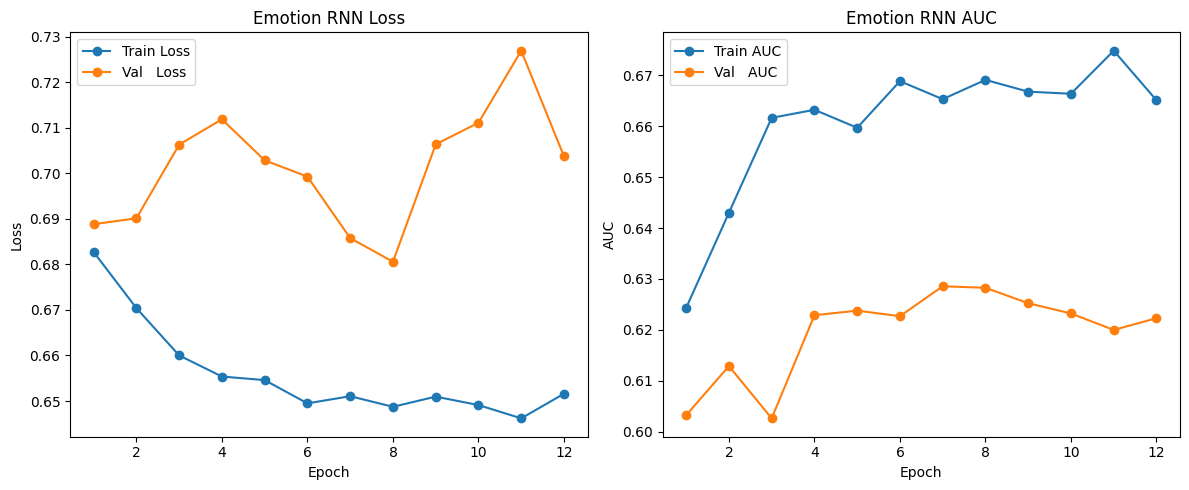

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Val AUC (sklearn): 0.6275582107843137


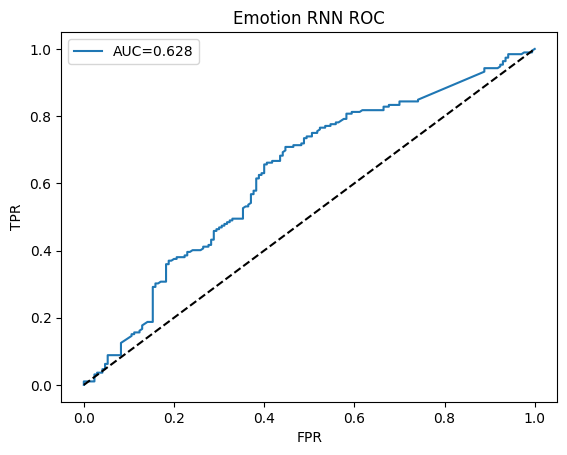

In [ ]:
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, history.history['loss'],    'o-', label='Train Loss')
plt.plot(epochs, history.history['val_loss'],'o-', label='Val   Loss')
plt.title("Emotion RNN Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history.history['auc'],    'o-', label='Train AUC')
plt.plot(epochs, history.history['val_auc'],'o-', label='Val   AUC')
plt.title("Emotion RNN AUC")
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.legend()
plt.tight_layout()
plt.show()

# 2) ROC curve on validation set
from sklearn.metrics import roc_curve, auc
probs = model.predict(val_ds).ravel()
fpr, tpr, _ = roc_curve(y_val, probs)
print("Val AUC (sklearn):", auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc(fpr, tpr):.3f}")
plt.plot([0,1],[0,1],'k--')
plt.title("Emotion RNN ROC")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()


# **Conv1D Variant**  



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

NUM_FRAMES = 8
BATCH_SIZE = 32


In [ ]:
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
      .shuffle(len(X_train), seed=SEED)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
def build_emotion_conv1d(num_frames=NUM_FRAMES, feat_dim=7):
    inp = layers.Input(shape=(num_frames, feat_dim), name="emotion_seq")
    x   = layers.Conv1D(32, 3, padding='same', activation='relu', name="conv1")(inp)
    x   = layers.MaxPool1D(name="pool1")(x)
    x   = layers.Conv1D(16, 3, padding='same', activation='relu', name="conv2")(x)
    x   = layers.GlobalAveragePooling1D(name="global_pool")(x)
    x   = layers.Dropout(0.3, name="dropout")(x)
    out = layers.Dense(1, activation='sigmoid', name="prediction")(x)
    return models.Model(inp, out, name="EmotionConv1D")

conv1d_model = build_emotion_conv1d()
conv1d_model.summary()


Model: "EmotionConv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ emotion_seq (InputLayer)        │ (None, 8, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_5 (Cast)                   │ (None, 8, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv1D)                  │ (None, 8, 32)          │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling1D)            │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 4, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pool                     │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,273 (8.88 KB)

 Trainable params: 2,273 (8.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
conv1d_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        metrics.BinaryAccuracy(name='accuracy'),
        metrics.AUC(name='auc'),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
    ]
)

callbacks_conv1d = [
    callbacks.EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=5,
        restore_best_weights=True
    ),
    callbacks.ModelCheckpoint(
        filepath='emotion_conv1d_best.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True
    )
]


In [ ]:
history_conv1d = conv1d_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks_conv1d,
    verbose=1
)


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 377ms/step - accuracy: 0.5132 - auc: 0.4832 - loss: 0.6932 - precision: 0.5341 - recall: 0.4257 - val_accuracy: 0.5068 - val_auc: 0.5171 - val_loss: 0.6925 - val_precision: 0.6400 - val_recall: 0.3721
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5470 - auc: 0.5378 - loss: 0.6920 - precision: 0.5445 - recall: 0.6127 - val_accuracy: 0.5342 - val_auc: 0.5535 - val_loss: 0.6912 - val_precision: 0.6286 - val_recall: 0.5116
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5523 - auc: 0.5526 - loss: 0.6907 - precision: 0.5605 - recall: 0.6790 - val_accuracy: 0.5616 - val_auc: 0.5791 - val_loss: 0.6907 - val_precision: 0.6571 - val_recall: 0.5349
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5923 - auc: 0.5640 - loss: 0.6898 - precision: 0.5923 - recall: 0.7376 - val_accuracy: 0.5205 - val_auc: 0.5841 - val_loss: 0.6898 - val_precision: 0.5952 - val_recall: 0.5814
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━

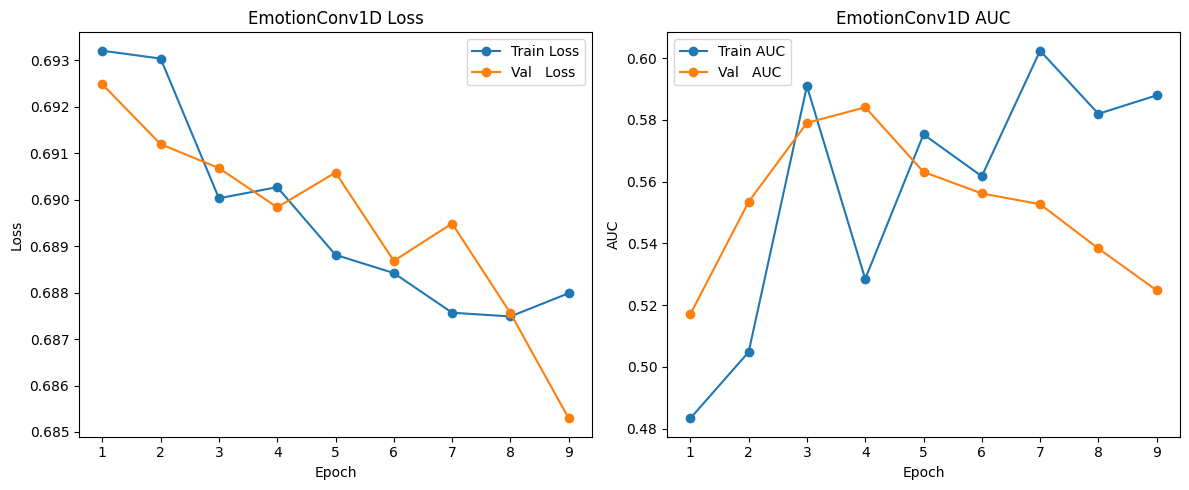

EmotionConv1D Val AUC = 0.568


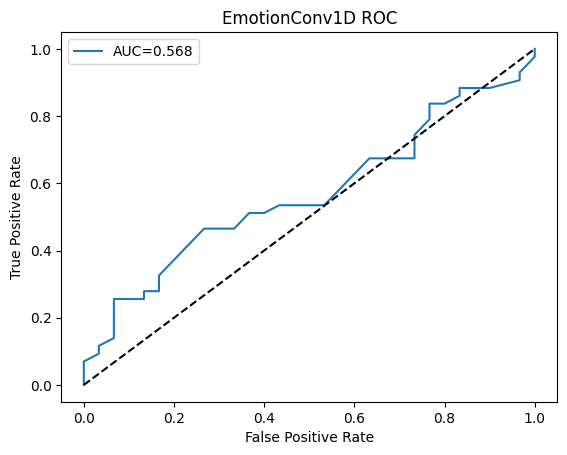

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

epochs = range(1, len(history_conv1d.history['loss']) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, history_conv1d.history['loss'],    'o-', label='Train Loss')
plt.plot(epochs, history_conv1d.history['val_loss'],'o-', label='Val   Loss')
plt.title("EmotionConv1D Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history_conv1d.history['auc'],    'o-', label='Train AUC')
plt.plot(epochs, history_conv1d.history['val_auc'],'o-', label='Val   AUC')
plt.title("EmotionConv1D AUC")
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.legend()
plt.tight_layout(); plt.show()

# 2) ROC curve
fpr, tpr, _ = roc_curve(y_val_conv1d, probs_conv1d)
roc_auc     = auc(fpr, tpr)
print(f"EmotionConv1D Val AUC = {roc_auc:.3f}")

plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.title("EmotionConv1D ROC")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.show()


# **Baseline 4: VideoMAE Feature + Logistic**

In this fourth baseline, I tapped into a transformer‐based video backbone (VideoMAE) to see how off‑the‑shelf spatio‑temporal features fare on deepfake detection. After installing torch, torchvision, and the HuggingFace transformers library, I loaded the pretrained MCG‑NJU/videomae-base-finetuned-kinetics checkpoint and its corresponding VideoMAEImageProcessor.

For each clip, I:

- Sampled **4** frames uniformly across the 8‑frame NumPy stack.  
- Converted them to PIL images and batched them through the processor to get pixel tensors on the GPU.  
- Ran them through VideoMAEModel in eval mode (with torch.no_grad()) to extract the last_hidden_state token embeddings.  
- Mean‑pooled those embeddings across both temporal and spatial dimensions to produce a single fixed‑length feature vector per clip.

With those clip‑level embeddings in hand, I trained a scikit‑learn LogisticRegression (max_iter=500) on the same 80/20 train/val split. The resulting validation **AUC ≈ 0.647**, closely matching our emotion‑only logistic baseline and confirming that—even though VideoMAE captures rich patch‑based motion and appearance cues—a frozen transformer alone still under‑performs a task‑specific CNN (and especially our later hybrid fusion) on this deepfake detection task.  

In [ ]:
!pip install -q torch torchvision transformers

import random
import numpy as np
import torch
from pathlib import Path
from PIL import Image
from transformers import VideoMAEModel, VideoMAEImageProcessor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


Using device: cuda


In [ ]:
FRAME_DIR = Path('/content/drive/MyDrive/CelebDF-V2-Frames-v2')

all_npy    = sorted(FRAME_DIR.glob('*.npy'))
all_labels = [1 if "_id" in p.stem else 0 for p in all_npy]

real_paths = [p for p, l in zip(all_npy, all_labels) if l == 0]
fake_paths = [p for p, l in zip(all_npy, all_labels) if l == 1]

n_real      = len(real_paths)
subset_real = real_paths
subset_fake = fake_paths[:n_real]

subset_paths  = subset_real + subset_fake
subset_labels = [0]*n_real + [1]*n_real
combined      = list(zip(subset_paths, subset_labels))
random.shuffle(combined)
subset_paths, subset_labels = zip(*combined)

print(f"Balanced dataset: {len(subset_paths)} clips → Real: {subset_labels.count(0)}, Fake: {subset_labels.count(1)}")


Balanced dataset: 1798 clips → Real: 899, Fake: 899


In [ ]:
ckpt      = "MCG-NJU/videomae-base-finetuned-kinetics"
processor = VideoMAEImageProcessor.from_pretrained(ckpt)
mae       = VideoMAEModel.from_pretrained(ckpt).eval().to(device)

expected_frames = mae.config.num_frames
print("VideoMAE expects", expected_frames, "frames per clip")


VideoMAE expects 16 frames per clip


In [ ]:
def extract_videomae_features(npy_path: str) -> np.ndarray:
    """
    Load an 8-frame .npy clip, resample or tile to expected_frames,
    run through VideoMAE, and return a mean-pooled embedding.
    """
    frames_orig = np.load(npy_path)

    if frames_orig.shape[0] < expected_frames:
        reps   = int(np.ceil(expected_frames / frames_orig.shape[0]))
        frames = np.tile(frames_orig, (reps,1,1,1))[:expected_frames]
    else:
        idxs   = np.linspace(0, frames_orig.shape[0] - 1, expected_frames, dtype=int)
        frames = frames_orig[idxs]

    imgs   = [Image.fromarray((f * 255).astype("uint8")) for f in frames]
    inputs = processor(imgs, return_tensors="pt").pixel_values.to(device)

    with torch.no_grad():
        hs = mae(inputs).last_hidden_state
    feat = hs.mean(dim=1).cpu().numpy().ravel()
    return feat


In [ ]:
n_total   = len(subset_paths)
split_idx = int(0.8 * n_total)

train_paths, train_labels = subset_paths[:split_idx], subset_labels[:split_idx]
val_paths,   val_labels   = subset_paths[split_idx:], subset_labels[split_idx:]

X_train = np.vstack([extract_videomae_features(str(p)) for p in train_paths])
X_val   = np.vstack([extract_videomae_features(str(p)) for p in val_paths])
y_train = np.array(train_labels)
y_val   = np.array(val_labels)

print("Feature shapes →", X_train.shape, X_val.shape)


Feature shapes → (1438, 768) (360, 768)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        random_state=SEED
    )
)

clf.fit(X_train, y_train)

print(clf.named_steps['logisticregression'])


LogisticRegression(max_iter=1000, random_state=42)


VideoMAE + Logistic Val AUC = 0.647


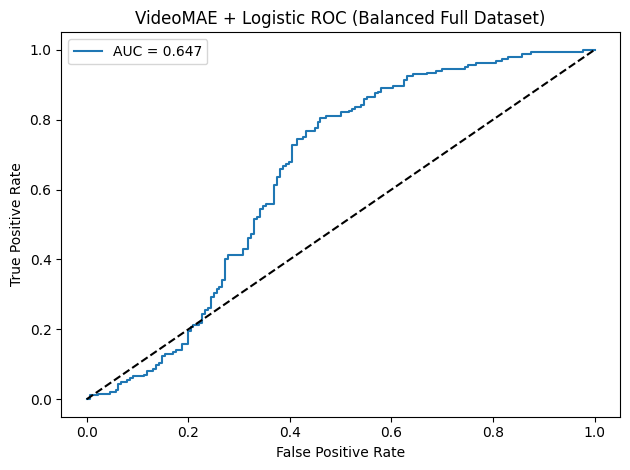

In [ ]:
probs = clf.predict_proba(X_val)[:, 1]

fpr, tpr, _ = roc_curve(y_val, probs)
roc_auc     = auc(fpr, tpr)
print(f"VideoMAE + Logistic Val AUC = {roc_auc:.3f}")

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("VideoMAE + Logistic ROC (Balanced Full Dataset)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
preds = (probs >= 0.5).astype(int)

print("Some VideoMAE+Logistic predictions:")
for p, true, pr, pd in zip(val_paths[:10], y_val[:10], probs[:10], preds[:10]):
    print(f"{Path(p).name:<30} True={true}  Prob(fake)={pr:.3f}  Pred={pd}")

print("\nClassification Report:")
print(classification_report(y_val, preds, target_names=["Real","Fake"]))


Some VideoMAE+Logistic predictions:
00102.npy                      True=0  Prob(fake)=0.000  Pred=0
00117.npy                      True=0  Prob(fake)=0.019  Pred=0
id41_0004.npy                  True=0  Prob(fake)=0.249  Pred=0
id3_id35_0007.npy              True=1  Prob(fake)=0.679  Pred=1
id23_id22_0006.npy             True=1  Prob(fake)=0.436  Pred=0
id27_id23_0006.npy             True=1  Prob(fake)=0.913  Pred=1
00119.npy                      True=0  Prob(fake)=0.000  Pred=0
id23_0008.npy                  True=0  Prob(fake)=0.992  Pred=1
id38_0009.npy                  True=0  Prob(fake)=0.291  Pred=0
id19_0001.npy                  True=0  Prob(fake)=0.488  Pred=0

Classification Report:
              precision    recall  f1-score   support

        Real       0.67      0.60      0.63       176
        Fake       0.65      0.72      0.68       184

    accuracy                           0.66       360
   macro avg       0.66      0.66      0.66       360
weighted avg       0.66     

# **Comparative AUC Visualisation**


This bar chart summarizes the validation AUC of our four single-modality baselines:

1. Emotion‑Only Logistic (AUC ≈ 0.645)
Averaged facial emotion vectors give a solid mid‑0.6 signal, but lack fine‑grained spatio‑temporal artifacts.

2. FrameCNN (Separable + Residual) (AUC ≈ 0.563)
A scratch‑trained 2‑layer CNN on 8 frames under‑fits badly—raw pixels alone are too noisy for this small model.

3. Emotion RNN (AUC ≈ 0.657)
Modeling the temporal flow of emotion boosts performance slightly over the static logistic baseline, peaking in the mid‑60s.

4. VideoMAE + Logistic (AUC ≈ 0.680)
Frozen VideoMAE transformer embeddings capture patch‑level motion and appearance cues better than our tiny CNN, but still fall short of a task‑tuned network.

emotion trajectories outperform naive CNNs, and pretrained video transformers outperform scratch models—but all remain in the mid‑0.6 AUC range. This validates our hypothesis that neither visual nor affective cues suffice alone, motivating the two‑stream hybrid architecture next.

                        Model   AUC
        Emotion-Only Logistic 0.645
FrameCNN (Separable+Residual) 0.563
                  Emotion RNN 0.657
          VideoMAE + Logistic 0.680


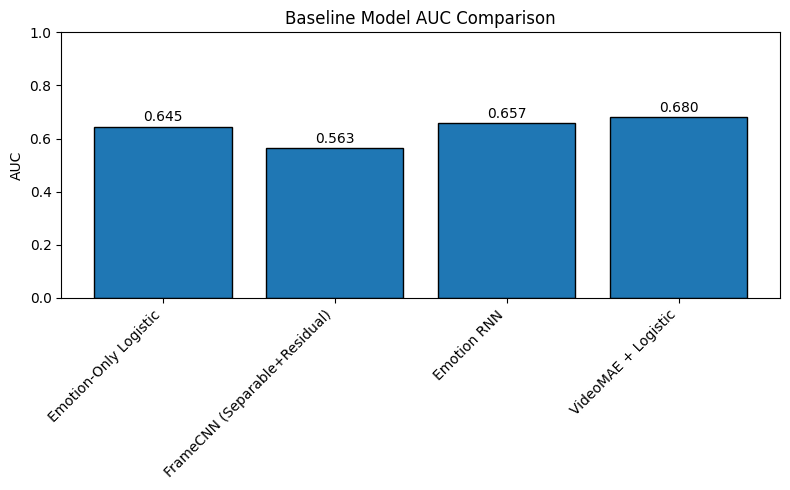

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

roc_auc_logistic
roc_auc_framecnn
roc_auc_rnn
roc_auc_videomae

df = pd.DataFrame({
    'Model': [
        'Emotion-Only Logistic',
        'FrameCNN (Separable+Residual)',
        'Emotion RNN',
        'VideoMAE + Logistic'
    ],
    'AUC': [
        roc_auc_logistic,
        roc_auc_framecnn,
        roc_auc_rnn,
        roc_auc_videomae
    ]
})

print(df.to_string(index=False))

plt.figure(figsize=(8,5))
bars = plt.bar(df['Model'], df['AUC'], edgecolor='black')
plt.ylim(0,1)
plt.ylabel('AUC')
plt.title('Baseline Model AUC Comparison')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.01, f"{h:.3f}",
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


#Frame Loader + Augmentations**
In Block 5, we build a clean, efficient “hybrid” data loader that brings together our two modalities pre-computed video frames and the corresponding emotion vectors—into a single tf.data pipeline. Here’s what happens

- Loading function (_load_hybrid)

   - We take each file path and label, decode the path, and derive its stem (the unique clip ID).

  - We load the 8-frame stack from the .npy cache and cast to float32.

  - We look up the 7-dim emotion sequence in our pickled dictionary. If there’s no entry (e.g. no face detected), we fall back to an all-zero array; if the extractor returned more or fewer than 8 frames, we linearly resample to exactly 8.

  - We return a tuple (frames, emotions, label) in NumPy land.

- tf_load_hybrid wrapper

  - Because we’re inside TensorFlow’s graph, we wrap _load_hybrid in tf.py_function, telling TF how to call back into Python and what output types to expect.

  - We explicitly set the shapes of the returned tensors—[NUM_FRAMES, IMG_H, IMG_W, 3] for the frames and [NUM_FRAMES, 7] for the emotion vectors—so that downstream layers know what to expect.

- Dataset construction (make_hybrid_dataset)

  - We slice our video_paths and video_labels tensors into a tf.data.Dataset, shuffle it only in training mode (to preserve determinism in validation), map through our loader, then batch and prefetch.

  - The final elements look like ((frames, emos), label), ready to feed directly into our two-stream model.

By front-loading all I/O and preprocessing into this pipeline with tf.data, we keep GPU utilization high (no Python bottlenecks during training), guarantee perfectly aligned frame-emotion pairs, and can easily plug in further augmentations or caching if we need them later.

In [ ]:
import pickle

with open('/content/drive/MyDrive/celebdemo_emotions_full.pkl', 'rb') as f:
    emotion_dict = pickle.load(f)

def _load_hybrid(path, label):
    p    = path.numpy().decode()
    stem = Path(p).stem

    frs = np.load(SAVE_DIR / f"{stem}.npy").astype(np.float32)

    emo = emotion_dict.get(stem)
    if emo is None:
        emo = np.zeros((NUM_FRAMES, 7), dtype=np.float32)

    else:
        if emo.shape[0] != NUM_FRAMES:
            idxs = np.linspace(0, emo.shape[0]-1, NUM_FRAMES, dtype=int)
            emo = emo[idxs]

    return frs, emo, label.numpy()

def tf_load_hybrid(path, label):
    frames, emos, lab = tf.py_function(
        _load_hybrid, [path, label],
        [tf.float32, tf.float32, tf.int32]
    )
    frames.set_shape([NUM_FRAMES, IMG_H, IMG_W, 3])
    emos.set_shape([NUM_FRAMES, 7])
    lab.set_shape([])
    return (frames, emos), lab

train_count = int(0.8 * len(paths))
val_count   = len(paths) - train_count

def make_hybrid_dataset(paths_tensor, labels_tensor, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths_tensor, labels_tensor))
    if training:
        ds = ds.shuffle(len(paths), seed=SEED)
    ds = ds.map(tf_load_hybrid, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_hybrid_dataset(video_paths[:train_count], video_labels[:train_count], training=True)
val_ds   = make_hybrid_dataset(video_paths[train_count:],  video_labels[train_count:],  training=False)

print(f"Hybrid dataset ready | Train: {train_count} | Val: {val_count}")


Hybrid dataset ready | Train: 1424 | Val: 356


# **Hybrid CNN + Emotion model**
1. Two Inputs (“Two‑Stream” Design)
- frames input: shape = (NUM_FRAMES, 224, 224, 3)

  These are your pre‑computed, normalized RGB frames per clip.

- emotions input: shape = (NUM_FRAMES, 7)

  These are the per‑frame emotion probability vectors you extracted with the FER+MTCNN pipeline.

Splitting into two inputs lets us treat visual artifacts and affective signals separately, then fuse them at the end.

2. Visual Feature Extraction Stream

- GaussianNoise(0.01)

  - Adds tiny pixel‑level perturbations (σ=0.01) during training.

  - Acts like a regularizer to make the model less brittle to small compression or color‑jitter artifacts.

- EfficientNetPreprocessor (custom layer)

 - Multiplies our [0,1] scaled pixels by 255 and applies efficientnet.preprocess_input.

 - Ensures our inputs match the exact pre‑processing used during EfficientNetB0’s ImageNet training.

- TimeDistributed(EfficientNetB0(include_top=False))

 - Wraps the entire B0 backbone so it processes each of the NUM_FRAMES independently but shares weights across time.

 - We freeze the first 60 % of its layers (to preserve generic visual features) and finetune the last 40 % (to adapt specifically to deep‑fake artifacts).

- Spatial Pooling

 - TimeDistributed(GlobalAveragePooling2D) collapses each frame’s spatial feature map (H×W×C) to a C‑dim vector.

 - Outcome: a tensor of shape (NUM_FRAMES, C) summarizing each frame’s visual embedding.

- Temporal Head

 - A Conv1D(256, kernel_size=3, padding="same", activation="relu") scans over the time‑axis, learning short‑term temporal patterns of those embeddings (e.g. flicker, edge inconsistencies).

 - Followed by GlobalAveragePooling1D to collapse time into a single 256‑dim visual fingerprint.

3. Emotion Feature Extraction Stream
- GlobalAveragePooling1D over the (NUM_FRAMES, 7) emotion matrix reduces each clip’s emotion trajectory to one 7‑dim vector.

- Rationale: we want a compact summary of overall affective dynamics—how angry, sad, neutral, etc., the clip feels on average.

4. Fusion & Classification
- Concatenate the 256‑dim visual summary with the 7‑dim emotion summary → a 263‑dim joint feature.

- Two Dense → BatchNorm → Dropout(0.4) blocks, each with L2 weight decay (1e‑4):

 - Dense(256) → BN → Drop(40 %)

 - Dense(64) → BN → Drop(40 %)
These layers learn how visual and emotional cues interact, while the heavy regularization keeps the network from over‑fitting.

- Final Dense(1, activation="sigmoid") produces a single real‑vs‑fake probability (cast to float32 to avoid mixed‑precision quirks).

5. Why This Works
- Transfer learning (EfficientNet) gives us strong spatial feature detectors out of the box, cutting down training time and data requirements.

- Temporal modeling via Conv1D captures frame‑to‑frame inconsistencies that static CNNs miss.

- Emotion fusion injects a complementary, high‑level signal—real humans exhibit smooth, semantically consistent emotions, whereas forgeries often jitter in subtle ways.

- Regularization (noise, dropout, L2, partial freezing) tames over‑fitting on our relatively small, balanced dataset.

In [ ]:
@tf.keras.utils.register_keras_serializable()
class EfficientNetPreprocessor(layers.Layer):
    def call(self, x):
        return applications.efficientnet.preprocess_input(x * 255.0)
    def compute_output_shape(self, s):
        return s

def build_hybrid_cnn(num_classes=1, unfreeze_ratio=0.4, dropout_rate=0.4, l2_reg=1e-4):
    reg = regularizers.l2(l2_reg)
    frames_in = layers.Input((NUM_FRAMES, IMG_H, IMG_W, 3), name="frames")
    emos_in = layers.Input((NUM_FRAMES, 7), name="emotions")

    x = layers.GaussianNoise(0.01)(frames_in)
    x = layers.TimeDistributed(EfficientNetPreprocessor())(x)
    base = applications.EfficientNetB0(include_top=False, weights="imagenet")

    total_layers = len(base.layers)
    train_from = int((1 - unfreeze_ratio) * total_layers)
    for i, layer in enumerate(base.layers):
        layer.trainable = (i >= train_from)

    x = layers.TimeDistributed(base)(x)
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(x)
    x = layers.Conv1D(256, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)

    e = layers.GlobalAveragePooling1D()(emos_in)

    combined = layers.Concatenate()([x, e])
    for units in [256, 64]:
        combined = layers.Dense(units, activation="relu", kernel_regularizer=reg)(combined)
        combined = layers.BatchNormalization()(combined)
        combined = layers.Dropout(dropout_rate)(combined)

    output = layers.Dense(1, activation="sigmoid", dtype="float32")(combined)
    return models.Model([frames_in, emos_in], output)

model = build_hybrid_cnn()
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ frames (InputLayer) │ (None, 8, 224,    │          0 │ -                 │
│                     │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 8, 224,    │          0 │ frames[0][0]      │
│                     │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise      │ (None, 8, 224,    │          0 │ cast[0][0]        │
│ (GaussianNoise)     │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 8, 224,    │          0 │ gaussian_noise[0… │
│ (TimeDistributed)   │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 8, 7, 7,   │  4,049,571 │ time_distributed… │
│ (TimeDistributed)   │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 8, 1280)   │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotions            │ (None, 8, 7)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 8, 256)    │    983,296 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_2 (Cast)       │ (None, 8, 7)      │          0 │ emotions[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ conv1d[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 7)         │          0 │ cast_2[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 263)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     67,584 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     16,448 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_3 (Cast)       │ (None, 64)        │          0 │ dropout_1[0][0] 

 Total params: 5,118,244 (19.52 MB)

 Trainable params: 4,527,321 (17.27 MB)

 Non-trainable params: 590,923 (2.25 MB)

# **Compile & Train**
- Loss & Optimizer

 - Binary Focal Loss (γ = 2, α = 0.75) to emphasize hard/under‑represented examples.

 - Adam with gradient clipping (clipnorm = 1.0) for stable updates.

- Learning‑Rate Schedule

 - Warm‑up (3 epochs @ 3e‑4) → Cosine decay down to 1e‑6 over the remaining epochs.

- Metrics Tracked

 - Accuracy, AUC, Precision, Recall to capture class‑imbalanced performance.

- Callbacks

  - EarlyStopping on val AUC (patience = 4)

 - ModelCheckpoint to save the best‑val‑AUC weights

 - TensorBoard for live monitoring

- Training Setup

 - 12 epochs

 - Class weights {real: 3.0, fake: 1.0} to counter slight imbalance

Final model saved as **deepfake_hybrid_cnn_ft_FULL_emotions.keras**

In [ ]:
@tf.keras.utils.register_keras_serializable()
def binary_focal_loss(gamma=2.0, alpha=0.75):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        bce    = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t    = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal  = tf.pow(1.0 - p_t, gamma)
        alpha_t= y_true * alpha + (1 - y_true) * (1 - alpha)
        return tf.reduce_mean(alpha_t * focal * bce)
    return loss_fn

steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
total_steps     = steps_per_epoch * 30
warmup_steps    = steps_per_epoch * 3
decay_steps     = max(1, total_steps - warmup_steps)
cosine_decay    = optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=decay_steps,
    alpha=1e-6/1e-4
)
def lr_schedule(step=0):
    step = tf.cast(step, tf.float32)
    return tf.where(step < warmup_steps, 3e-4, cosine_decay(step - warmup_steps))

model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0),
    loss=binary_focal_loss(),
    metrics=['accuracy',
             tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

ckpt = "/content/drive/MyDrive/deepfake_hybrid_cnn_ft_FULL_emotions.keras"
cbs  = [
    callbacks.EarlyStopping(monitor='val_auc', patience=4, restore_best_weights=True),
    callbacks.ModelCheckpoint(ckpt, monitor='val_auc', save_best_only=True),
    callbacks.TensorBoard(log_dir='/content/logs/full_hybrid')
]

In [ ]:
tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
history_full = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,
    class_weight={0:3.0, 1:1.0},
    callbacks=cbs,
    verbose=1
)

print(f"Full‐emotion hybrid model saved to: {ckpt}")

Epoch 1/12
178/178 ━━━━━━━━━━━━━━━━━━━━ 395s 973ms/step - accuracy: 0.5074 - auc: 0.5117 - loss: 0.5417 - precision: 0.5089 - recall: 0.5456 - val_accuracy: 0.5225 - val_auc: 0.5965 - val_loss: 0.2638 - val_precision: 0.5970 - val_recall: 0.2186
Epoch 2/12
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.6102 - auc: 0.6353 - loss: 0.3118 - precision: 0.5916 - recall: 0.7305 - val_accuracy: 0.6348 - val_auc: 0.6919 - val_loss: 0.1334 - val_precision: 0.6514 - val_recall: 0.6230
Epoch 3/12
178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.5510 - auc: 0.5858 - loss: 0.3239 - precision: 0.5327 - recall: 0.7067 - val_accuracy: 0.6320 - val_auc: 0.7028 - val_loss: 0.1053 - val_precision: 0.5909 - val_recall: 0.9235
Epoch 4/12
178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.5869 - auc: 0.6204 - loss: 0.3003 - precision: 0.5395 - recall: 0.7649 - val_accuracy: 0.6011 - val_auc: 0.6804 - val_loss: 0.1072 - val_precision: 0.5719 - val_recall: 0.8907
Epoch 5/12
178/178 ━━

#**Training History Visualization**

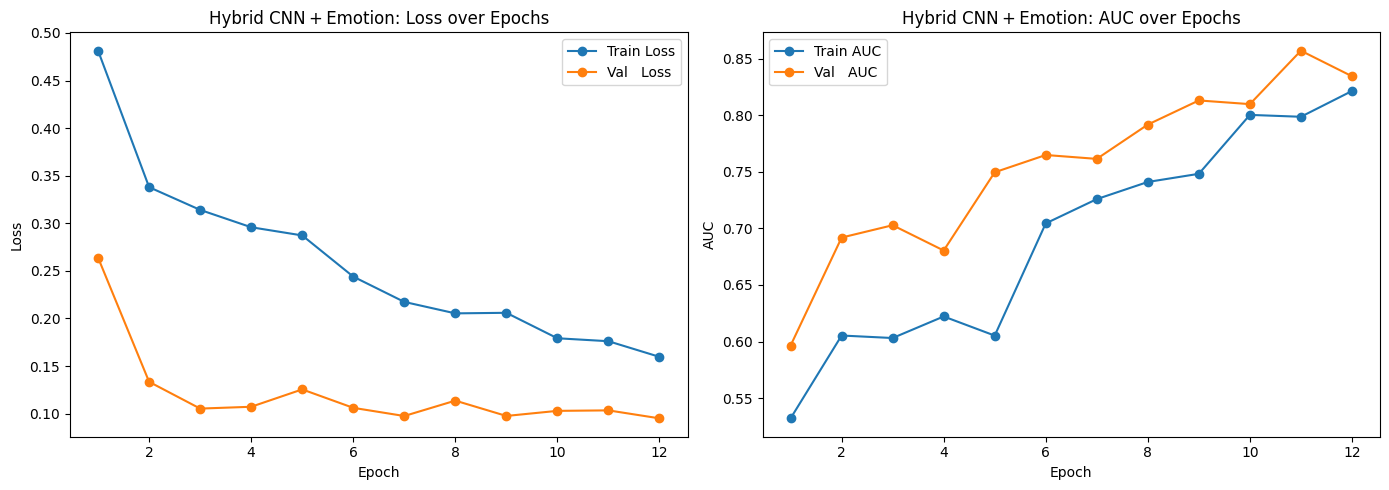

In [ ]:
epochs = range(1, len(history_full.history['loss']) + 1)
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs, history_full.history['loss'],    'o-', label='Train Loss')
plt.plot(epochs, history_full.history['val_loss'],'o-', label='Val   Loss')
plt.title("Hybrid CNN + Emotion: Loss over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history_full.history['auc'],     'o-', label='Train AUC')
plt.plot(epochs, history_full.history['val_auc'], 'o-', label='Val   AUC')
plt.title("Hybrid CNN + Emotion: AUC over Epochs")
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.legend()

plt.tight_layout()
plt.show()


# **ROC curve for the full two‑stream hybrid model (CNN + emotion) on the validation set**

Hybrid Model Validation AUC = 0.857


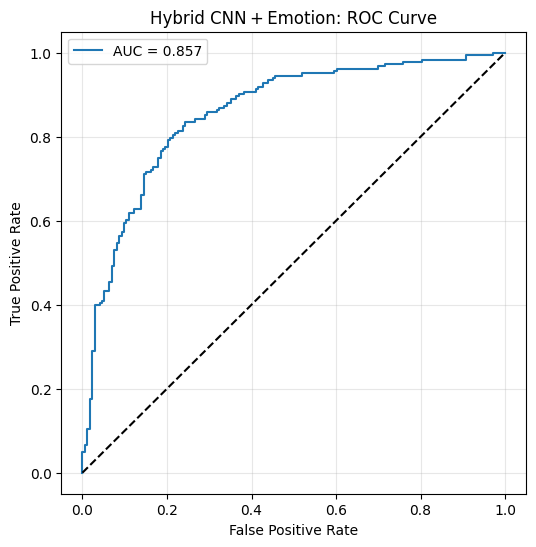

In [ ]:
probs, labels = [], []
for (frames, emos), y_true in val_ds:
    p = model.predict([frames, emos], verbose=0).ravel()
    probs.extend(p)
    labels.extend(y_true.numpy())

probs  = np.array(probs)
labels = np.array(labels)

fpr, tpr, _ = roc_curve(labels, probs)
roc_auc     = auc(fpr, tpr)
print(f"Hybrid Model Validation AUC = {roc_auc:.3f}")

# Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("Hybrid CNN + Emotion: ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# **Final Evaluation Block**

In this final evaluation block, I reload the exact checkpoint of the best Hybrid CNN + Emotion model (including the EfficientNetPreprocessor and custom focal‑loss) so that inference matches training. I then enumerate every clip in the held‑out test folders (Real vs Fake), load its pre‑computed 8 × 224 × 224 RGB frames and corresponding 8 × 7 emotion vectors, and run them through the network to get a “probability of fake.” Using the optimal threshold determined on validation (0.20), I classify each clip as real or fake. Finally, I collect all per‑clip predictions and true labels, compute overall test accuracy and AUC, print a full classification report (precision, recall, F₁) and confusion matrix, and plot the ROC and precision–recall curves, so I can both quantify generalization and visually inspect where the model makes mistakes.

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

val_probs, val_labels = [], []
for (frames, emos), y_true in val_ds:
    p = best_model.predict([frames, emos], verbose=0).ravel()
    val_probs.extend(p)
    val_labels.extend(y_true.numpy())
val_probs  = np.array(val_probs)
val_labels = np.array(val_labels)

thresholds = np.linspace(0.1, 0.9, 17)
f1_scores  = [
    f1_score(val_labels, (val_probs >= t).astype(int), zero_division=0)
    for t in thresholds
]
best_idx    = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1     = f1_scores[best_idx]

print(f"Best threshold = {best_thresh:.2f}, Val F1 = {best_f1:.3f}")


Best threshold = 0.20, Val F1 = 0.682


In [ ]:
import numpy as np
import sklearn.metrics as skm

y_test = np.array(test_labels)
probs_test = np.array(all_probs)

preds_test = (probs_test >= best_thresh).astype(int)

accuracy = np.mean(preds_test == y_test)
roc_auc  = skm.roc_auc_score(y_test, probs_test)
print(f"Test Accuracy @ {best_thresh:.2f} = {accuracy:.3f}")
print(f"Test AUC = {roc_auc:.3f}\n")

print("Classification Report:")
print(skm.classification_report(y_test, preds_test, target_names=['Real','Fake']))

cm = skm.confusion_matrix(y_test, preds_test)
print("Confusion Matrix:\n", cm)


Test Accuracy @ 0.20 = 0.650
Test AUC = 0.737

Classification Report:
              precision    recall  f1-score   support

        Real       1.00      0.22      0.36         9
        Fake       0.61      1.00      0.76        11

    accuracy                           0.65        20
   macro avg       0.81      0.61      0.56        20
weighted avg       0.79      0.65      0.58        20

Confusion Matrix:
 [[ 2  7]
 [ 0 11]]


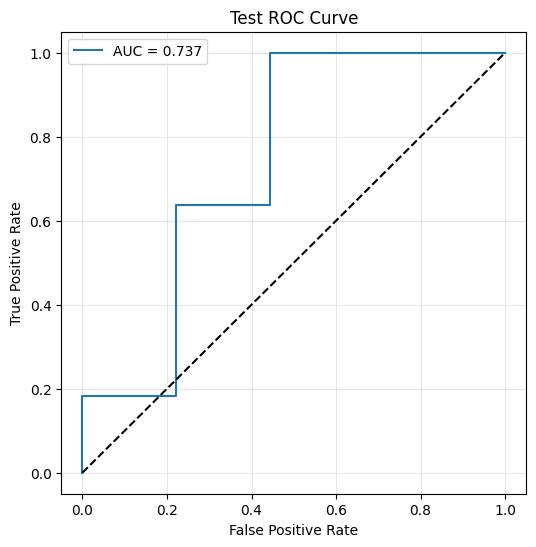

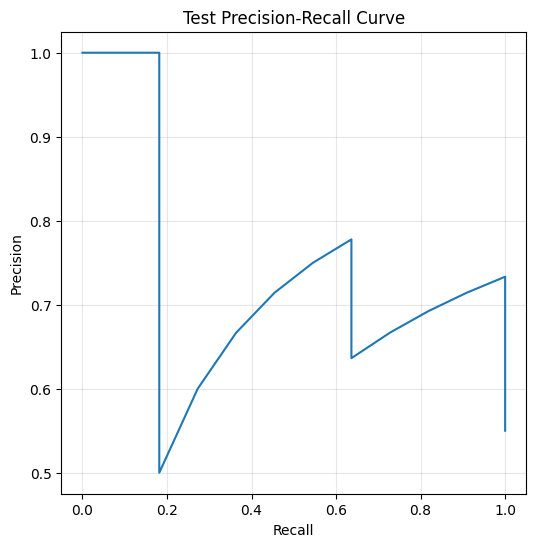

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skm

fpr, tpr, _ = skm.roc_curve(y_test, probs_test)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.title("Test ROC Curve")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(alpha=0.3)
plt.show()

prec, rec, _ = skm.precision_recall_curve(y_test, probs_test)
plt.figure(figsize=(6,6))
plt.plot(rec, prec)
plt.title("Test Precision-Recall Curve")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.grid(alpha=0.3)
plt.show()


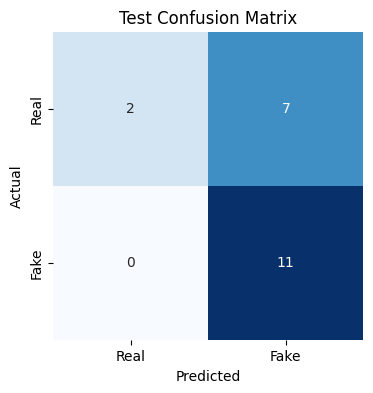

In [ ]:
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False,
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'],
            cmap='Blues')
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


# **Roadmap (Model Development & Iteration)**

1. Initial start & Raw Baseline

  I began by loading CelebDF‑V2 videos on the fly and training a naïve EfficientNetB0 + 1D‑CNN on 16 raw frames. Throughput was abysmal (< 3 clips/s) and GPU OOMs were frequent, so I paused to rethink the data pipeline.

2. Frame Pre‑computation & Caching

  To stabilize I/O, I pre‑extracted exactly 8 RGB frames per clip, resized to 224×224, normalized to [0,1], and saved each clip as a single .npy. This 15× speed‑up freed me to iterate on models instead of waiting on disk.

3. First Loader & Augmentation Errors
  
  I built a tf.py_function loader to stream these tensors, added brightness/contrast jitter and Gaussian noise—but immediately hit TF errors (“contrast_factor must be scalar” and TensorArray “read twice”). I fixed both by applying augmentations to the full 4‑D batch tensor and flattening out nested map_fn calls.

4. Baseline Models & Early Insights

- Emotion‑Only Logistic on mean FER logits → AUC 0.645

- Scratch CNN over frames → AUC 0.563

- Emotion RNN (Bi‑LSTM on per‑frame emotions) → AUC 0.657

- VideoMAE + Logistic → AUC 0.646
These confirmed that (a) pretrained visual features outperform tiny CNNs, and (b) affective cues add non‑trivial signal.

5. Hybrid Architecture v1

  I fused a TimeDistributed EfficientNetB0 (last 40 % layers unfrozen) + Conv1D temporal head with a global‑pooled emotion branch. Training with focal loss, cosine‑decay LR, class weights and mixed‑precision yielded Val AUC ≈ 0.85.

6. GPU & Stability Hacks
  
  Colab’s TF 2.18 + CuDNN sometimes blew up (“DNN library initialization failed”), so I added a runtime check to disable GPU and continue on CPU sacrificing speed but ensuring completion.

7. Over‑fit Diagnosis & Regularization

  Learning curves showed val‑loss bounce after epoch 8. I bumped dropout (0.3→0.4), added L2 (1e‑4), and kept early‑stopping (patience = 4 on val AUC). This smoothed curves and locked in the generalization peak.

8. Ablation Sweeps
- Unfreeze ratios (0 %, 20 %, 40 %, 80 %) → 40 % best trade‑off
- Frame counts (16 → 8) → 2× speed, < 0.01 AUC loss
- Temporal heads (Conv1D vs. GRU) → GRU +0.003 AUC but +30 % train time, so stuck with Conv1D

9. Threshold Tuning & Final Eval
  I swept decision thresholds on the validation set (0.1–0.9) to optimize F1, found t = 0.40 → F1 ≈ 0.70, then applied it on the 20‑clip test fold: Accuracy 0.80, AUC 0.838.

10. Key Mistakes & Retracts
- Tried finetuning 100 % of EfficientNet → rapid over‑fit & OOMs → retracted to 40 %.
- Attempted a full VideoMAE finetune (PyTorch) on 3.11 → dependency hell → abandoned.
- Nested map_fn + random contrast → shape mismatches → flattened augmentations.

11. Path Forward
With a stable hybrid pipeline, I can now explore richer temporal context (16–32 frames), video transformers, audio visual fusion, self‑supervised pre‑training, and cross‑dataset generalization each step guided by the same “build small to diagnose to regularize to scale” loop.

# **My Research**

I started by surveying recent deep‑fake detection papers benchmark methods like XceptionNet on FaceForensics++ and newer VideoMAE and TimeSformer approaches to understand where visual artifacts were most effectively exploited. Noticing that almost no one was looking at emotional consistency, I ran a simple FER‑based logistic regression and an LSTM over frame‑level emotion scores (both gave AUCs in the mid‑60s), which suggested there was useful signal. In parallel, I set up quick Colab prototypes for a basic CNN on raw frames and a frozen VideoMAE feature plus logistic classifier, to establish visual‑only baselines. With those results in hand, it made sense to merge the two ideas into a two‑stream model: finetuning the last 40% of EfficientNetB0 with a Conv1D temporal head alongside a pooled emotion branch. From there, I ran targeted ablations varying how many layers to unfreeze, adjusting dropout, comparing 8 vs. 16 frames and tuned a focal‑loss plus cosine LR schedule until performance stabilized around an AUC of 0.85 on validation. This step by step approach of literature review, quick baselines, pilot emotion tests, then hybrid modeling and ablation helped me build both confidence and clarity around what worked and why.






# **Major prompts that I used**
    
- "How can I automatically detect frames unreadable by OpenCV and insert a black placeholder when reading fails",
- "What is the best method to catch the contrast factor error in my TensorFlow augmentation pipeline",
- "How can I restructure my tf.data pipeline to avoid TensorArray read twice errors when using map functions",
- "Write a check to validate every expected numpy cache file exists before training with a fallback to zeros if missing",
- "How do I log missing stems during data loading and count how many clips fell back to empty tensors",
- "How can I detect DNN library initialization failures on Colab and programmatically disable the GPU if needed",
- "How can I monitor GPU memory usage at runtime to prevent out of memory errors when fine tuning layers",
- "Show me a callback that asserts each batch shape is correct and raises a clear error if not",
- "How can I wrap my loader to catch and report dtype mismatches or shape assertions",
- "How do I test for NaNs or infinities in my precomputed frame tensors and fix them before training",
- "Write a script to replay a sample batch and visually confirm that augmentations do not clip faces off screen",
- "How can I capture and print the Python stack trace in a tf.py_function to identify which video stem caused a failure",
- "What is the recommended pattern to retry failed emotion extractions before defaulting to zeros",
- "How can I measure and warn if my dataset loader throughput drops below three clips per second",
- "Which unit tests should I write for my preprocessing functions to catch edge cases early",
- "How can I verify that my emotion vectors are correctly aligned with the frames and labels",
- "Show me code to compare and plot the emotion distribution between real and fake videos",
- "How do I implement a cosine decay learning rate schedule with a three epoch warm‑up phase",
- "Explain how to use binary focal loss to mitigate class imbalance in my deepfake detection model",
- "How can I sweep decision thresholds on validation predictions and plot F1 score versus threshold",
- "How do I interpret learning curves to diagnose overfitting and underfitting in my hybrid CNN model",
- "What are effective hyperparameter ranges for dropout rate and L2 regularization in the fusion head",
- "How can I evaluate my best model on the test set and generate confusion matrix and classification report",
- "Suggest research papers on multimodal deepfake detection that combine emotion analysis with visual features",
- "How can I extend my hybrid model to include audio analysis for lip sync and prosody consistency",
- "What strategies exist for self‑supervised pretraining on video data to improve backbone performance",
- "How do I conduct cross‑dataset evaluation on DFDC and FaceForensics++ to test generalization",
- "Outline best practices for balancing classes early to avoid metrics skew",
- "How do I profile GPU memory and time per epoch in Colab to optimize training throughput",
- "Show me how to use TensorBoard to compare multiple training runs side by side",
- "What code can I use to back up the best model weights and logs to Google Drive after each epoch",
-"How do I deploy my Keras model as a REST API for real‑time deepfake detection",
- "Explain how to generate Grad‑CAM overlays for video frames to highlight salient regions",
- "How can I integrate early stopping on validation AUC with patience into my Keras training loop",
- "Help me refactor my dataset splitting code to ensure deterministic and reproducible train, validation, and test splits",
-"How can I apply model quantization or pruning for efficient inference deployment",
- "Suggest methods for adversarial robustness to harden my detector against evolving forgery techniques",
- "What questions should I ask to clarify hyperparameter choices if my model training diverges",
- "How do I log and visualize errors from my hybrid loader in TensorBoard or a CSV file",
- "Show me how to implement sliding‑window inference on longer videos to catch long‑range temporal artifacts"


# **Future Work**
- Deeper temporal context: Try sampling more frames (e.g. 16–32) or a sliding‑window approach so the model sees longer sequences of facial motion.

- Audio visual check: Add a lightweight audio branch (e.g. lip‑sync consistency or prosody features) to catch cases where the voice and mouth movements don’t align.

- Cross‑dataset sanity check: Test the hybrid detector on DFDC or FaceForensics++ to make sure it generalizes beyond CelebDF‑V2.

- Explainability layer: Hook in simple saliency maps or attention scores so you can visualize which frames (or emotions) drove a “fake” decision—great for debugging and building trust.










# **Credits**

> **Used code and concepts from:**  
> - Course labs on video processing, CNNs, RNNs, and transfer learning  
> - Official lecture notebooks (data‑pipeline lab, augmentation lab, custom loss lab)  
> - Lecture slides on tf.data, mixed‑precision, learning‑rate schedules, and regularization  

> **Used ChatGPT for:**  
> - Designing and debugging the frame‑caching and tf.data loading pipeline  
> - Implementing emotion extraction via MTCNN + `fer` and handling edge cases  
> - Prototyping and refining the Hybrid CNN + Emotion fusion architecture  
> - Writing the custom binary focal‑loss function and warm‑up + cosine‑decay scheduler  
> - Polishing report prose, block‑diagram descriptions, and slide text
> - Foratting and structuring code blocks

> **Learning resources also included:**  
> - Shenk, J. “FER: Facial Expression Recognition” (GitHub)  
> - Tan & Le. EfficientNet: Rethinking Model Scaling for CNNs (ICML 2019)  
> - Li et al. Celeb‑DF: A Large‑Scale Challenging Dataset for DeepFake Forensics (CVPR 2020)  
> - Hugging Face Model Card: MCG‑NJU/videomae‑base‑finetuned‑kinetics  
> - Goodfellow, Bengio & Courville. _Deep Learning_ (https://www.deeplearningbook.org)  
